# Utilis 
## Run for all tasks！

In [2]:
import sys
import os
import pandas as pd
sys.path.append('../..')
from Core.Utils.utils import *


c:\Users\13330\.conda\envs\Shenzhen_GLM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set working location: Cluster or Local

**Large data over 100MB**: data_path 


**smaller data under 10MB**: local git path


In [3]:
import glob
from abc import ABC, abstractmethod
import os
import umap
import numpy as np
import pandas as pd
import pandas as pd
from functools import partial
# Define the partial function with a fixed folder and embedding_folder
def search_csv_file(environment_path,search_folder,file_name):
    # Create a partial function to capture the pattern matching
    pattern = os.path.join(environment_path, search_folder, '**', file_name)
    return glob.glob(pattern, recursive=True)[0]  # Get the first match

# Example usage
folder = 'your_main_folder'
def random_sample(df, percentage=0.1):
    """
    Randomly sample a percentage of rows from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to sample from.
    percentage (float): The percentage of rows to sample (default is 0.1).
    
    Returns:
    pd.DataFrame: A DataFrame containing the sampled rows.
    """
    return df.sample(frac=percentage)
class PathStrategy(ABC):
    """
    Strategy interface for getting data paths.
    """
    def __init__(self, environment_path: str) -> None:
        self.environment_path = environment_path

    @abstractmethod
    def get_data_path(self):
        pass

    def find_file_from_data_path(self, filename: str):
        """
        Utility method to find a file with a specific name within the data directory.
        """
        search_path = os.path.join(self.get_data_path(), '**', filename)
        matching_files = glob.glob(search_path, recursive=True)
        if matching_files:
            return matching_files[0]  # Return the first match found
        else:
            raise FileNotFoundError(f"{filename} not found in {self.get_data_path()}")


class LocalPathStrategy(PathStrategy):
    def get_data_path(self):
        # Implementation specific to local paths
        return f"{self.environment_path}/Data"


class ClusterPathStrategy(PathStrategy):
    def get_data_path(self):
        # Implementation specific to cluster paths
        return f"{self.environment_path}/Data"


class WorkPath:
    def __init__(self, location: str) -> None:
        self.location = location
        self.environment_path = self._get_environment_path()
        self.path_strategy = self._create_path_strategy()

    @property
    def data_path(self):
        return self.path_strategy.get_data_path()

    def find_file_from_data_path(self, filename: str):
        print('This is find path',self.path_strategy.find_file_from_data_path(filename))
        return self.path_strategy.find_file_from_data_path(filename)

    def _get_environment_path(self):
        """
        Get the environment path based on the location.
        """
        if self.location == 'cluster':
            return '/mnt/yizhou/'
        elif self.location == 'local':
            return 'C:/Users/13330/OneDrive/工作/深圳---先进院/深圳--先进院--实习'
    
    def _create_path_strategy(self):
        """
        Create the appropriate path strategy based on the location.
        """
        if self.location == 'cluster':
            return ClusterPathStrategy(self.environment_path)
        elif self.location == 'local':
            return LocalPathStrategy(self.environment_path)





In [4]:

class ESMEmbedding:
    def __init__(self, work_path: WorkPath):
        self.work_path = work_path

    @property
    def esm2_embedding(self):
        return load_esm_embedding(self.work_path.find_file_from_data_path('total_esm2_embedding.pkl'))

    @property
    def esm3_embedding(self):
        return load_esm_embedding(self.work_path.find_file_from_data_path('total_esm3_normalized_embedding.pkl'))


def get_umap_embeddings(esm_embedding, umap_config):
    # Configure UMAP parameters for Euclidean distance

    # Compute UMAP embedding using Euclidean distance
    umap_reducer = umap.UMAP(**umap_config)
    umap_embedding = umap_reducer.fit_transform(esm_embedding)

    return umap_embedding

import seaborn as sns
def creat_cosomo_embedding(umap_embedding,signature_label):
    umap_df = pd.DataFrame(umap_embedding,columns=['x','y'])
    umap_df['type'] = signature_label
    umap_df['id'] = umap_df.index

    #get color for each id
    labels = umap_df['type'] #type is label
    unique_labels = np.unique(labels)
    # 生成基础调色板
    base_palette = sns.color_palette("tab10", n_colors=len(unique_labels))
    # 为每个唯一标签创建颜色映射，对于 "no_pfam" 使用灰色，其他使用 "Set1" 调色板
    # 确保为所有标签分配颜色，包括缺失的
    palette = {label: (base_palette[i]) for i, label in enumerate(unique_labels)}
    umap_df['color'] = umap_df['type'].map(palette)
    return umap_df

def save_cosmo_embedding(umap_df,out_name):
    umap_df.to_csv(f'/mnt/yizhou/Shenzhen_GLM_Project/Output/ESM/ESM_Embedding_Cosmograph/{out_name}.csv')

import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

def plot_scatter_with_labels(euc_df, cos_df):
    """
    Plot scatter plots with labels from two DataFrames: one for Euclidean distance and one for Cosine similarity.

    Parameters:
    euc_df (pd.DataFrame): DataFrame containing columns 'x', 'y', 'type', and 'color' for Euclidean distance.
    cos_df (pd.DataFrame): DataFrame containing columns 'x', 'y', 'type', and 'color' for Cosine similarity.
    """
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))

    # Plot Euclidean distance scatter plot
    unique_labels = euc_df['type'].unique()
    for label in unique_labels:
        subset = euc_df[euc_df['type'] == label]
        axes[0].scatter(subset['x'], subset['y'], color=subset['color'].iloc[0], label=label, s=10)
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    axes[0].set_title('UMAP Embedding with Euclidean Distance')
    axes[0].legend()

    # Plot Cosine similarity scatter plot
    unique_labels = cos_df['type'].unique()
    for label in unique_labels:
        subset = cos_df[cos_df['type'] == label]
        axes[1].scatter(subset['x'], subset['y'], color=subset['color'].iloc[0], label=label, s=10)
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    axes[1].set_title('UMAP Embedding with Cosine Similarity')
    axes[1].legend()

    plt.show()
# Example of setting up the environment
LOCATION = 'local'
work_path = WorkPath(LOCATION)


In [99]:
total_interpro_df = pd.read_csv(work_path.find_file_from_data_path('total_fasta_interpro.tsv'),sep='\t')

In [ ]:

#add columns to raw data
# new_column_names = [
#     'Protein accession',
#     'Sequence MD5 digest',
#     'Sequence length',
#     'Analysis',
#     'Signature accession',
#     'Signature description',
#     'Start location',
#     'Stop location',
#     'Score',
#     'Status',
#     'Date',
#     'InterPro annotations - accession',
#     'InterPro annotations - description',
#     'GO annotations',
#     'Pathways annotations'
# ]
#total_interpro_df.columns = new_column_names # add columns to raw data

#total_interpro_df.to_csv('/mnt/yizhou/Data/Label/total_fasta_interpro.tsv',sep='\t',index=False,header=True) # save to file

# ESM-2 Embedding with UMAP

## Extract embedding 

In [264]:
esm_embedding, esm_embedding_accession = ESMEmbedding(work_path).esm3_embedding

## Find top 10 pfam from Interpro scan

In [265]:
import pandas as pd
interpro_result = pd.read_csv(work_path.find_file_from_data_path('total_fasta_interpro.tsv'),sep='\t')
#sort by protein accession
interpro_result = interpro_result.sort_values(by='Protein accession')

In [268]:
import numpy as np
def get_top_pfam_labels(interpro_result,top=10):
    """
    args:
        interpro_result: interpro result dataframe
        top: top n most frequent labels of pfam
    """

    #filter labels from pfam database
    pfam_labels = interpro_result[interpro_result['Analysis']=='Pfam']
    # top 10 most frequent labels
    top_labels = pfam_labels['Signature description'].value_counts().index[:top]
    # filter data with top 10 labels
    top_labels_data = pfam_labels[pfam_labels['Signature description'].isin(top_labels)].reset_index(drop=True)

    return top_labels_data 

def get_non_duplicated_top_pfam_labels(top_pfam_labels):
    #remove duplicated protein accessions
    top_pfam_labels = top_pfam_labels.drop_duplicates(subset=['Protein accession'])
    return top_pfam_labels


def get_non_duplicated_pfam_labels(interpro_result):
    # Keep rows where the Analysis column is 'Pfam'
    pfam_labels = interpro_result[interpro_result['Analysis'] == 'Pfam']
    
    # Find protein accessions that do not have Pfam annotations
    non_pfam_proteins = interpro_result[~interpro_result['Protein accession'].isin(pfam_labels['Protein accession'])]
    
    # From non_pfam_proteins, keep the first occurrence of each protein accession
    non_pfam_unique = non_pfam_proteins.drop_duplicates(subset=['Protein accession'], keep='first')
    
    # Combine Pfam annotations with unique non-Pfam annotations, ensuring no duplicates in the final result
    combined_result = pd.concat([pfam_labels, non_pfam_unique]).drop_duplicates(subset=['Protein accession'], keep='first')
    
    return combined_result

def get_top_pfam_labels_embedding(top_pfam_labels,esm_embedding,esm_embedding_accession):
    """
    args:
        top_pfam_labels: non duplicated top pfam labels
        esm_embedding: esm embedding : list
        esm_embedding_accession: esm embedding accession : list
    """
    #get top pfam labels embedding
    esm_embedding_array = np.array(esm_embedding)
    esm_embedding_accession_array = np.array(esm_embedding_accession)
    #sort all the raw sequences and top sequences first!
    sort_indices = np.argsort(esm_embedding_accession_array)
    esm_embedding_array = esm_embedding_array[sort_indices]
    esm_embedding_accession_array = esm_embedding_accession_array[sort_indices]
    #sort target sequences and their corresponding labels!
    target_sequences_array = np.array(top_pfam_labels['Protein accession'].values)
    target_sequences_label_array = np.array(top_pfam_labels['Signature description'].values)
    sort_indices = np.argsort(target_sequences_array)
    target_sequences_array = target_sequences_array[sort_indices]
    target_sequences_label_array = target_sequences_label_array[sort_indices]
    #get target sequences from raw sequences
    target_mask = np.isin(esm_embedding_accession_array,target_sequences_array)
    target_esm_embedding_array = esm_embedding_array[target_mask]

    return target_esm_embedding_array,target_sequences_label_array,target_mask,target_sequences_array
    




## extract embeddings from those pfam labels

In [273]:
top_labels_data = get_top_pfam_labels(interpro_result,top=10)
top_labels_data = get_non_duplicated_top_pfam_labels(top_labels_data)
top_labels_embedding,top_labels,top_mask,top_sequences = get_top_pfam_labels_embedding(top_labels_data,esm_embedding,esm_embedding_accession)


In [274]:
esm_embedding_accession_df = pd.DataFrame(esm_embedding_accession,columns=['Protein accession'])
esm_embedding_accession_df.sort_values(by='Protein accession',inplace=True) #sort by protein accession

pfam_labels = interpro_result[interpro_result['Analysis'] == 'Pfam'].reset_index(drop=True) #all pfam annonated labels

#get if top_10 labels
esm_embedding_accession_df['if_is_top10_pfam'] = top_mask.astype(bool)


#merge all sequences with pfam labels
esm_embedding_accession_df = pd.merge(esm_embedding_accession_df,pfam_labels[['Protein accession','Signature description']],on='Protein accession',how='left')
esm_embedding_accession_df['Signature description'] = esm_embedding_accession_df['Signature description'].apply(lambda x: x if x in top_labels else 'No Pfam') #replace non top 10 labels or Nan with 'No Pfam'


In [275]:
from tqdm import tqdm
def deduplicate_group(group):
    # Check if there are any non 'No Pfam' labels
    non_no_pfam = group[group['Signature description'] != 'No Pfam']
    if not non_no_pfam.empty:
        # If there are non 'No Pfam' labels, keep one of them
        return non_no_pfam.iloc[:1] # return dataframe :()
    else:
        # Otherwise, keep one of the rows with 'No Pfam'
        return group.iloc[:1]

# Apply deduplication function to each group with progress bar
grouped = esm_embedding_accession_df.groupby('Protein accession')

# Use tqdm to show progress
deduplicated_df_list = []
for name, group in tqdm(grouped, total=len(grouped)):
    deduplicated_df_list.append(deduplicate_group(group))

deduplicated_df = pd.concat(deduplicated_df_list, ignore_index=True)

100%|██████████| 128012/128012 [01:15<00:00, 1694.44it/s]


In [276]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

umap_config_euc = {
    'n_neighbors':15,
    'n_components':2,
    'metric':'euclidean',
    'min_dist':0.5,
    'local_connectivity':1,
    'randome_state':42
}

umap_config_cos = {
    'n_neighbors':15,
    'n_components':2,
    'metric':'cosine',
    'min_dist':0.5,
    'local_connectivity':1,
    'random_state':42
}

#get sorted esm_embedding array.
esm_embedding_accession_array = np.array(esm_embedding_accession)
sort_indices = np.argsort(esm_embedding_accession_array)
esm_embedding_array = np.array(esm_embedding)[sort_indices]


#get cosine and euclidean reduce embeddings
umap_reducer_euc = umap.UMAP(**umap_config_euc)
umap_embedding_euc = umap_reducer_euc.fit_transform(esm_embedding_array)

umap_reducer_cos = umap.UMAP(**umap_config_cos)
umap_embedding_cos = umap_reducer_cos.fit_transform(esm_embedding_array)

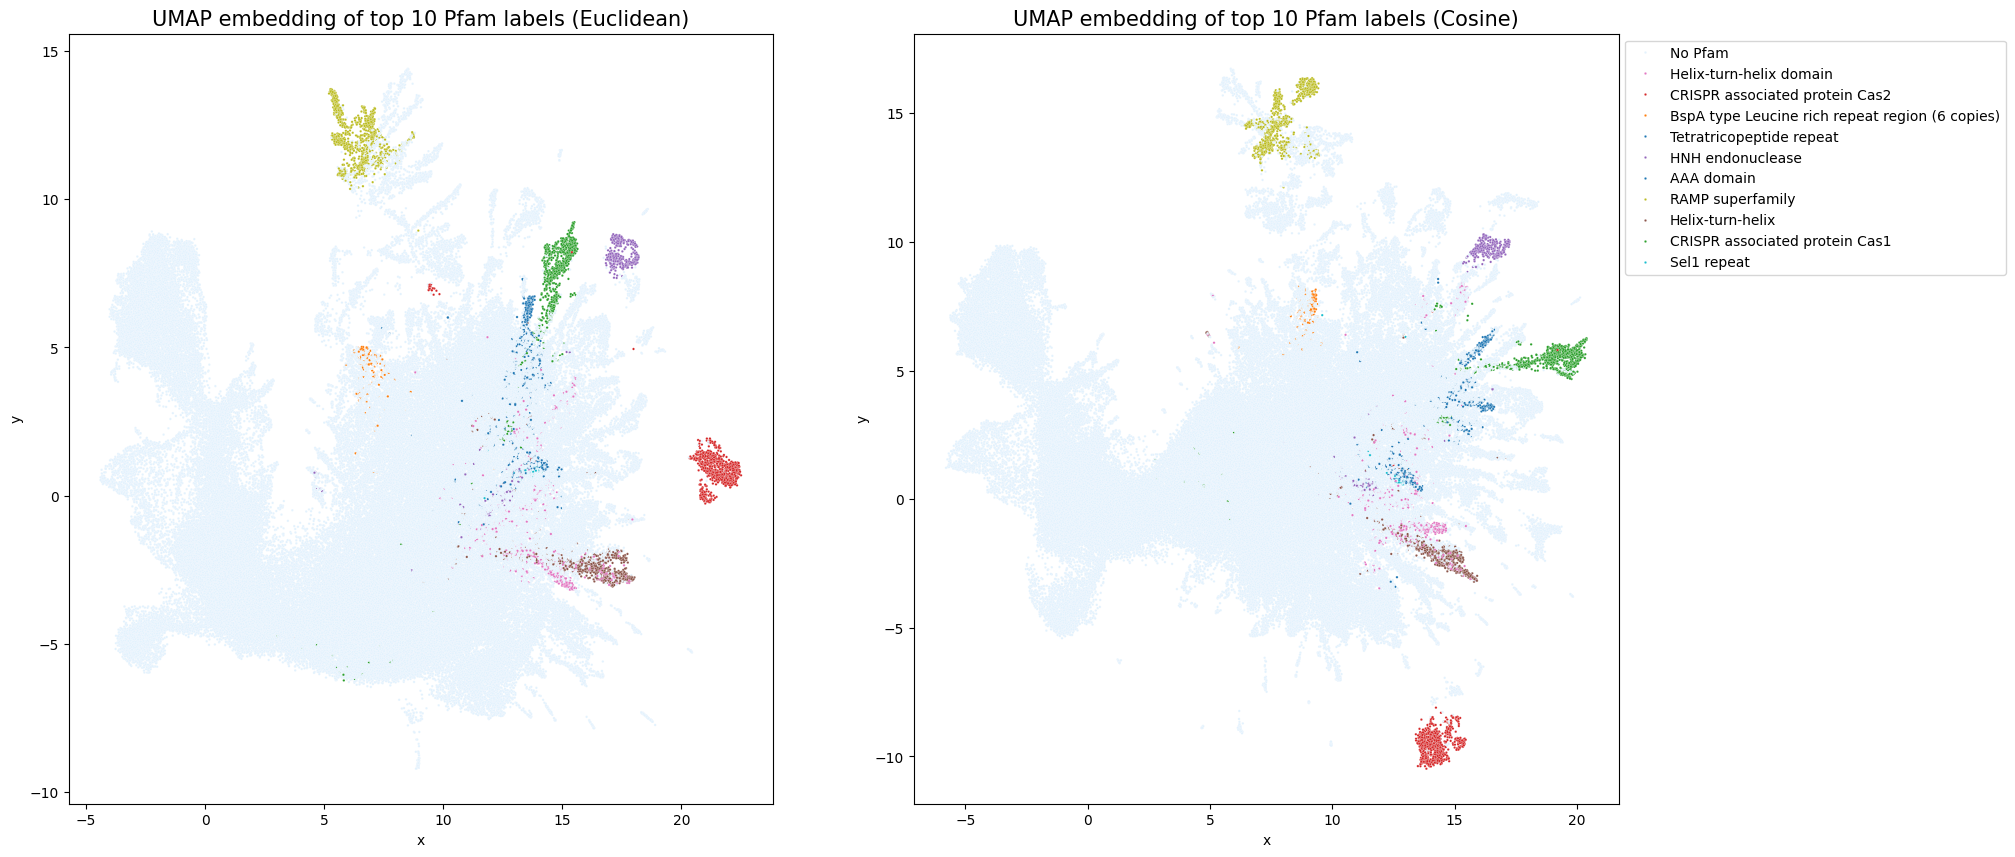

In [277]:

#get umap_df
umap_df_euc = pd.DataFrame(umap_embedding_euc,columns=['x','y'])
umap_df_cos = pd.DataFrame(umap_embedding_cos,columns=['x','y'])
umap_df_euc['type'] = deduplicated_df['Signature description']
umap_df_cos['type'] = deduplicated_df['Signature description']

umap_df_euc['id'] = deduplicated_df.index
umap_df_cos['id'] = deduplicated_df.index
#before drawing set parameters
labels = umap_df_euc['type'] #type is label
unique_labels = np.unique(labels)

# 生成基础调色板
base_palette = sns.color_palette("tab10", n_colors=len(unique_labels))

# 为每个唯一标签创建颜色映射，对于 "no_pfam" 使用灰色，其他使用 "Set1" 调色板
# 确保为所有标签分配颜色，包括缺失的
palette = {label: ('#E3F2FD' if label == 'No Pfam' else base_palette[i]) for i, label in enumerate(unique_labels)}
# 将图例放置到右上角，且不介入图中
# 绘制散点图，使用更新的调色板
# 创建两个子图
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 绘制EUC的UMAP散点图
sns.scatterplot(x=umap_df_euc.x, y=umap_df_euc.y, hue=labels, palette=palette, s=3, ax=axes[0])
axes[0].set_title("UMAP embedding of top 10 Pfam labels (Euclidean)", fontsize=15)

# 生成COS数据的标签
labels_cos = umap_df_cos['type']

# 绘制COS的UMAP散点图
sns.scatterplot(x=umap_df_cos.x, y=umap_df_cos.y, hue=labels, palette=palette, s=3, ax=axes[1])
axes[1].set_title("UMAP embedding of top 10 Pfam labels (Cosine)", fontsize=15)

#去掉legend
axes[0].get_legend().remove()
axes[1].get_legend().remove()
#最右边画legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [11]:
#umap_df_euc = pd.read_csv('/mnt/yizhou/Data/Label/umap_all_embedding_euclidean_top_10_pfam.csv')
#umap_df_cos = pd.read_csv('/mnt/yizhou/Data/Label/umap_all_embedding_cosine_top_10_pfam.csv')
base_palette = sns.color_palette("tab10", n_colors=len(unique_labels))
from matplotlib.colors import rgb2hex
# 为每个唯一标签创建颜色映射，对于 "No Pfam" 使用灰色，其他使用 "tab10" 调色板
# 确保为所有标签分配颜色，包括缺失的
palette = {label: (rgb2hex('#E3F2FD') if label == 'No Pfam' else rgb2hex(base_palette[i])) for i, label in enumerate(unique_labels)}

palette_df = pd.DataFrame(palette.items(), columns=['type', 'node_color'])

merged_umap_euc = pd.merge(umap_df_euc, palette_df, on='type', how='left')
merged_umap_cos = pd.merge(umap_df_cos, palette_df, on='type', how='left')




# Task2 Statistics of embedding

## Prepare for Data


In [145]:
import pandas as pd
import sys
import os
from tqdm import tqdm
from Core.Utils.utils import *

total_interpro_df = pd.read_csv(work_path.find_file_from_data_path('total_fasta_interpro.tsv'),sep='\t')
#load esm embedding and labels
esm_embedding, esm_embedding_accession = ESMEmbedding(work_path).esm3_embedding


#create df
esm_all_df = pd.DataFrame({
                        'Protein accession': esm_embedding_accession,
                        'esm_embedding':esm_embedding})
esm_all_df = esm_all_df.sort_values(by='Protein accession').reset_index(drop=True)



This is find path C:/Users/13330/OneDrive/工作/深圳---先进院/深圳--先进院--实习/Data\Data\Label\total_fasta_interpro.tsv
This is find path C:/Users/13330/OneDrive/工作/深圳---先进院/深圳--先进院--实习/Data\Data\Preparation_Data\total_esm3_normalized_embedding.pkl


## Subtask 2.1More details in local Cas protein/ Cluster for Cas1, Cas2, and together.

### First get proteins with label Cas1/2

In [151]:
import numpy as np
target_labels = ['CRISPR associated protein Cas1','CRISPR associated protein Cas2']
#get corresponding pfam
interpro_cas_all = total_interpro_df[total_interpro_df['Signature description'].isin(target_labels)]
interpro_cas_all = interpro_cas_all[interpro_cas_all['Analysis'] == 'Pfam']
#drop duplicated (some seqs have both cas1 cas2, keep these) 
interpro_cas = interpro_cas_all.drop_duplicates(subset=['Protein accession','Signature description'])
interpro_cas = interpro_cas.loc[:, ['Protein accession', 'Signature description']].reset_index(drop=True)

In [153]:
#merge with all esm
interpro_cas = pd.merge(interpro_cas,esm_all_df,how='left',on='Protein accession')
interpro_cas_embedding, interpro_cas_labels = np.vstack(interpro_cas.esm_embedding.values),np.vstack(interpro_cas.loc[:,'Signature description'].values)

### Then prepare for umap cas1/cas2/cas1&2


Cas1&2

In [154]:
umap_config_euc = {
        'n_neighbors': 15,
        'n_components': 2,
        'metric': 'euclidean',
        'min_dist': 0.5,
        'local_connectivity': 1,
        'random_state':42
    }

    # Configure UMAP parameters for Cosine distance
umap_config_cos = {
    'n_neighbors': 15,
    'n_components': 2,
    'metric': 'cosine',
    'min_dist': 0.5,
    'local_connectivity': 1,
    'random_state':42
}
umap_embedding_euc = get_umap_embeddings(interpro_cas_embedding,umap_config_euc)
umap_embedding_cos = get_umap_embeddings(interpro_cas_embedding,umap_config_cos)


c:\Users\13330\.conda\envs\Shenzhen_GLM\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\13330\.conda\envs\Shenzhen_GLM\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


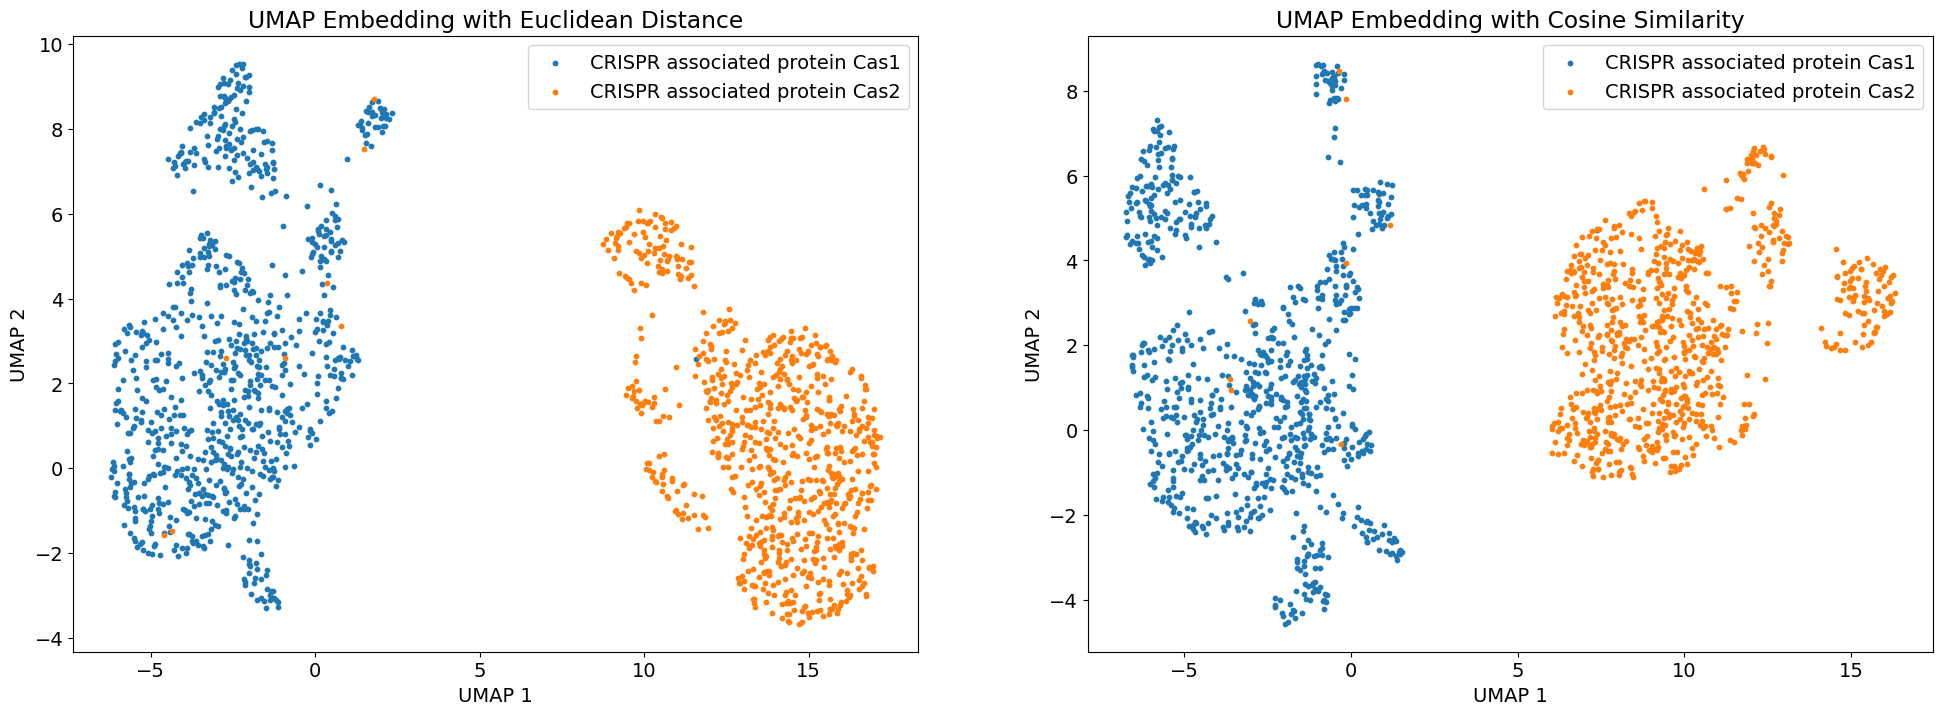

In [155]:
import matplotlib.pyplot as plt
umap_embedding_euc_df = creat_cosomo_embedding(umap_embedding_euc,interpro_cas_labels)
umap_embedding_cos_df = creat_cosomo_embedding(umap_embedding_cos,interpro_cas_labels)
plot_scatter_with_labels(umap_embedding_euc_df,umap_embedding_cos_df)

Cas1 only Umap

And add Ids of subcluster in umap of all embeddings

In [156]:
umap_config_euc = {
        'n_neighbors': 15,
        'n_components': 2,
        'metric': 'euclidean',
        'min_dist': 0.3,
        'local_connectivity': 1,
        'random_state':42
    }

    # Configure UMAP parameters for Cosine distance
umap_config_cos = {
    'n_neighbors': 15,
    'n_components': 2,
    'metric': 'cosine',
    'min_dist': 0.3,
    'local_connectivity': 1,
    'random_state':42
}
#get only cas1
interpro_cas1 = interpro_cas[interpro_cas['Signature description'] == 'CRISPR associated protein Cas1'].reset_index(drop=True)
interpro_cas1_embedding, interpro_cas1_labels = np.vstack(interpro_cas1.esm_embedding.values),np.vstack(interpro_cas1.loc[:,'Signature description'].values)
umap_embedding_cas1_euc = get_umap_embeddings(interpro_cas1_embedding,umap_config_euc)
umap_embedding_cas1_cos = get_umap_embeddings(interpro_cas1_embedding,umap_config_cos)

c:\Users\13330\.conda\envs\Shenzhen_GLM\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\13330\.conda\envs\Shenzhen_GLM\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


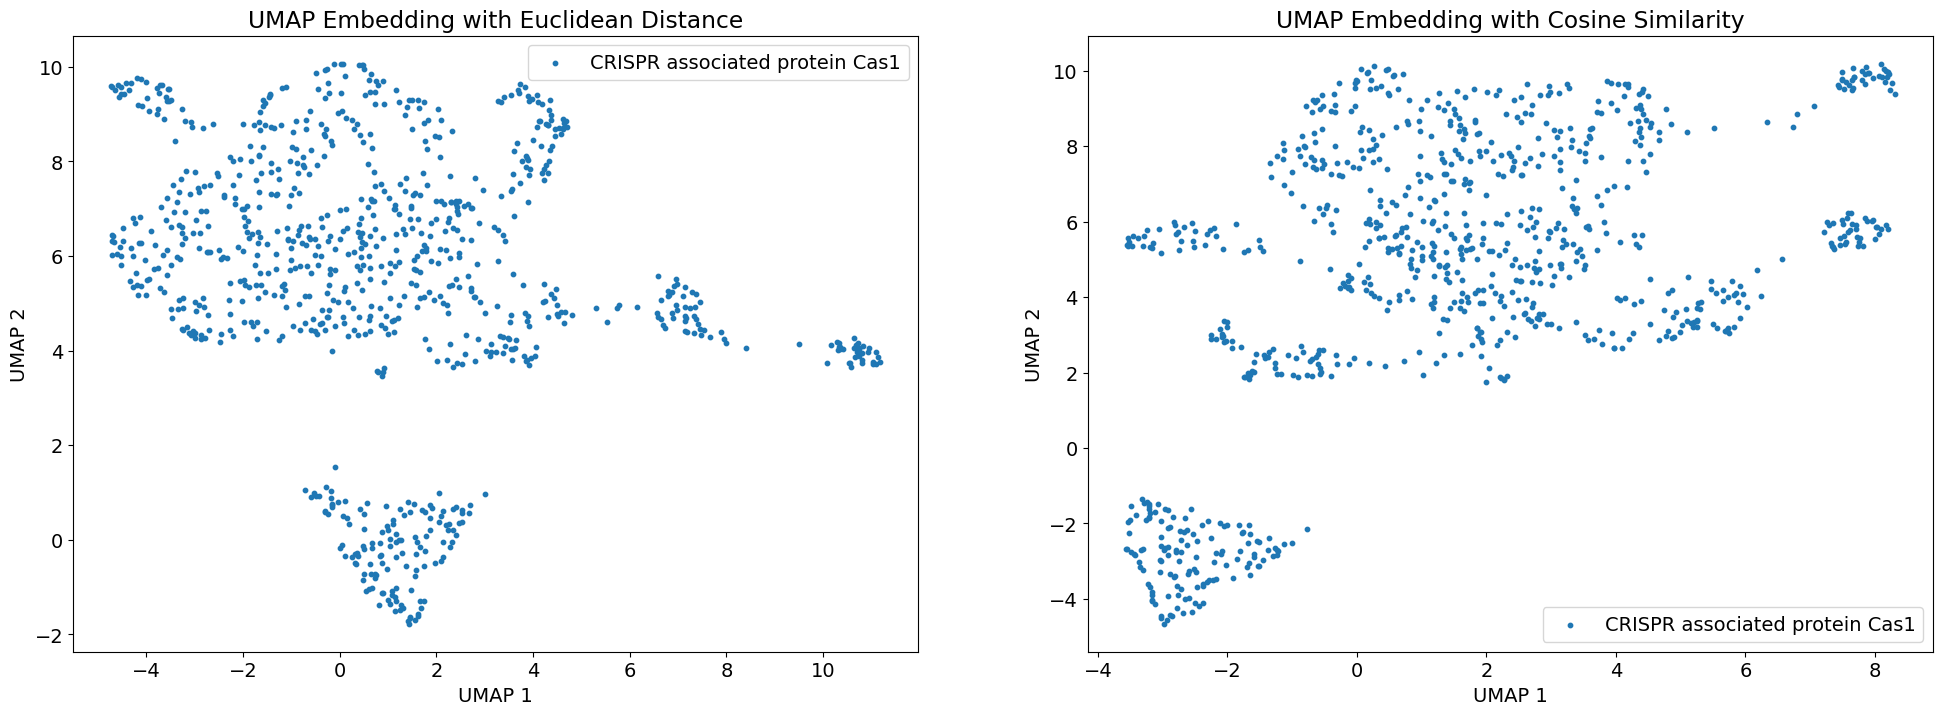

In [157]:
umap_embedding_cas1_euc_df = creat_cosomo_embedding(umap_embedding_cas1_euc,interpro_cas1_labels)
umap_embedding_cas1_cos_df = creat_cosomo_embedding(umap_embedding_cas1_cos,interpro_cas1_labels)
plot_scatter_with_labels(umap_embedding_cas1_euc_df,umap_embedding_cas1_cos_df)

Add ids of subcluster and show them in different colors

In [163]:
#get sorted esm all by protein accession
esm_all_df = esm_all_df.sort_values(by='Protein accession').reset_index(drop=True)
# get ids of subcluster of cas1 from cosmograph
cas1_subcluster_1_ids = [
    1221, 1389, 1638, 2184, 2235, 2522, 2585, 2622, 3645, 3823, 
    4214, 4405, 4490, 4516, 4845, 4848, 5045, 5531, 5567, 5656, 
    5727, 6565, 6628, 6979, 7275, 7365, 7585, 7626, 7715, 7875, 
    8180, 8241, 8265, 8344, 8541, 8680, 8748, 9091, 9099, 9292, 
    9417, 9642, 9739, 13177, 13396, 13433, 13500, 13514, 14558, 14748, 
    15023, 15131, 15510, 15597, 15661, 16132, 16224, 16797, 16839, 17003, 
    17055, 17068, 17280, 17378, 17469, 17697, 17714, 17759, 17764, 17774, 
    18126, 18334, 18577, 19438, 19581, 19649, 19895, 20223, 20619, 20768, 
    20844, 21088, 21231, 21392, 21476, 21481, 21494, 21721, 22170, 22865, 
    23296, 23409, 23511, 23761, 23807, 23827, 24005, 24196, 24526, 24973, 
    25177, 25192, 25402, 25625, 25750, 25904, 25976, 26039, 26101, 26205, 
    26739, 27073, 27464, 27636, 27645, 27753, 27786, 27799, 27990, 28505, 
    28805, 29022, 29044, 29233, 30138, 30159, 30598, 30642, 30780, 30843, 
    31136, 31152, 31180, 31498, 31562, 31568, 31604, 31628, 32170, 32283, 
    32425, 33105, 33124, 33323, 33380, 33498, 33530, 33678, 33790, 34126, 
    34307, 35033, 35106, 35524, 35612, 36043, 36886, 37103, 37214, 37402, 
    37494, 37723, 37883, 37984, 38146, 38337, 38503, 38965, 39092, 39405, 
    39811, 39826, 40045, 40115, 40170, 40173, 40222, 40296, 40354, 40536, 
    40588, 40969, 41225, 41273, 41274, 41583, 41655, 41783, 41881, 42303, 
    42305, 42344, 42390, 42514, 42727, 42852, 42856, 42936, 43026, 43491, 
    43634, 43757, 43894, 44137, 44185, 44200, 44368, 44752, 44785, 44823, 
    45162, 45213, 45309, 45549, 45730, 46272, 46281, 46292, 46300, 46864, 
    46936, 46947, 47241, 47390, 47556, 47783, 47963, 48238, 48281, 48284, 
    48312, 48413, 48597, 48889, 48908, 49150, 49243, 49315, 49369, 49515, 
    49849, 50000, 50293, 50663, 50676, 50712, 51052, 51122, 51136, 51176, 
    51323, 51658, 51820, 52079, 52155, 52369, 52534, 52572, 52583, 53283, 
    53711, 54326, 54683, 55248, 55323, 55527, 55800, 56012, 56242, 56657, 
    56866, 57809, 58825, 58931, 59158, 59338, 60473, 61095, 61878, 62040, 
    62539, 62693, 63183, 64553, 65369, 65469, 65811, 65958, 66264, 66275, 
    66333, 66508, 66568, 66849, 66868, 67128, 67264, 67285, 67845, 68088, 
    68620, 68960, 69125, 69189, 69681, 69867, 69898, 69969, 71624, 71767, 
    72101, 72359, 72411, 72522, 72541, 72677, 73029, 73146, 73244, 73463, 
    73698, 73725, 74600, 74604, 75061, 75380, 75388, 75583, 76266, 76288, 
    76996, 77004, 77160, 77622, 78152, 78195, 78272, 78494, 78546, 79101, 
    79131, 79254, 79674, 80040, 80401, 81011, 81049, 81145, 81281, 81356, 
    81603, 82087, 82373, 82552, 82574, 82617, 82819, 83050, 83051, 83096, 
    83205, 83211, 83257, 83290, 83308, 83333, 83510, 83885, 84059, 84193, 
    84367, 84481, 84601, 84612, 84642, 85071, 85191, 85387, 85409, 85416, 
    85717, 85718, 85725, 86019, 86035, 86115, 86119, 86444, 86468, 86540, 
    86585, 86606, 86638, 86639, 87546, 87774, 87858, 88014, 88656, 88865, 
    89005, 89084, 89233, 90010, 90028, 90038, 90496, 90672, 90918, 91096, 
    91163, 91176, 91233, 91316, 91491, 91644, 92615, 92813, 93043, 93386, 
    94045, 94090, 94108, 94158, 94189, 94630, 94761, 94799, 94811, 94837, 
    94839, 94849, 94884, 94912, 94970, 95262, 95271, 95280, 95296, 95306, 
    95433, 96335, 96368, 96573, 96833, 96867, 96910, 97074, 97329, 97370, 
    98808, 99671, 99956, 100136, 100686, 100970, 101028, 101045, 101482, 
    101694, 101856, 101925, 101977, 102204, 102412, 102574, 102592, 103402, 
    103629, 103753, 104220, 104753, 104833, 104837, 104984, 105500, 106079, 
    106814, 106842, 107039, 107127, 107412, 107604, 107670, 107727, 107828, 
    107977, 108025, 108154, 108340, 109163, 109304, 109339, 109836, 109956, 
    110012, 110055, 110163, 110177, 110705, 111033, 111125, 111506, 111525, 
    111598, 111704, 112102, 112159, 112180, 112233, 112493, 112557, 113121, 
    113128, 113246, 113549, 113795, 114303, 118222, 119056, 120277, 120393, 
    120544, 120837, 120897, 120917, 120920, 120968, 121069, 121469, 122123, 
    123808, 123987, 124118, 124380, 124471, 124484, 124561, 124612, 125058, 
    125168, 125687, 125964, 126459, 126526, 126651, 126773, 127094, 127239, 
    127564, 127577, 127606, 127770, 127980
]
cas1_subcluster_2_ids  = [
     314, 2379, 3105, 4143, 4155, 4429, 5003, 5583, 5617, 6053, 
     7395, 8075, 8284, 9098, 16120, 16605, 16609, 17316, 17384, 17520, 
     17805, 17935, 18373, 18382, 18751, 19482, 19932, 21315, 21599, 22215, 
     22780, 24992, 25206, 25228, 25852, 26059, 26408, 26963, 27025, 27030, 
     27991, 28170, 28215, 28943, 29094, 29226, 30352, 33057, 33228, 33539, 
     34097, 34165, 34864, 35995, 36137, 38608, 41325, 41844, 42004, 43715, 
     44202, 44789, 45448, 45546, 45845, 46242, 46329, 46830, 47534, 47881, 
     48732, 48766, 49378, 49631, 53323, 53443, 53616, 53729, 53821, 54333, 
    59896, 60083, 60219, 60862, 60947, 61481, 63863, 64016, 64095, 64538, 
     64688, 69127, 69396, 71972, 72530, 72779, 73045, 74638, 75495, 75572, 
     77840, 78257, 78500, 78712, 79382, 80171, 80802, 81770, 82282, 83572, 
     83674, 84420, 84707, 85216, 85287, 85727, 85811, 86644, 88150, 91282, 
     91456, 91590, 92807, 93866, 93882, 93960, 94808, 95410, 96832, 96883, 
     98439, 98615, 100597, 101499, 104969, 106670, 107174, 107688, 108438, 
     108801, 109027, 109247, 111049, 111168, 111832, 112582, 112916, 113524, 
     119994, 120381, 120383, 121731, 123154, 123158, 124530, 126375, 127539, 
     127594, 127667, 127672
 ]

cas1_subcluster_3_ids = [
    2577, 13447, 26474, 26595, 28451, 29355, 32361, 41341, 42259, 42810, 
    45182, 45968, 47257, 50806, 50909, 54349, 57326, 60247, 61665, 63047, 
    64588, 71660, 76287, 83907, 85417, 85786, 86570, 87827, 89601, 91300, 
    91453, 95228, 96884, 106576, 106843, 107597, 107603, 109164, 110754, 
    112810, 112962, 113010, 113033, 113052, 124023
]
cas1_subcluster_4_ids = [
    3988, 9107, 11695, 13345, 15165, 16472, 16775, 17639, 17960, 23644, 
    23850, 26085, 38712, 42561, 45325, 47880, 52925, 56506, 80098, 80800, 
    81654, 88987, 89853, 98112, 100713, 102426, 107729, 109791, 111235, 
    112099, 126646
]


cas1_subcluster_1_protein_accessions = esm_all_df.loc[cas1_subcluster_1_ids, 'Protein accession'].values
cas1_subcluster_2_protein_accessions = esm_all_df.loc[cas1_subcluster_2_ids, 'Protein accession'].values
cas1_subcluster_3_protein_accessions = esm_all_df.loc[cas1_subcluster_3_ids, 'Protein accession'].values
cas1_subcluster_4_protein_accessions = esm_all_df.loc[cas1_subcluster_4_ids, 'Protein accession'].values

interpro_cas1['Cluster'] = interpro_cas1.apply(lambda x: '1' if x['Protein accession'] in cas1_subcluster_1_protein_accessions 
                                             else '2' if x['Protein accession'] in cas1_subcluster_2_protein_accessions
                                             else '3' if x['Protein accession'] in cas1_subcluster_3_protein_accessions
                                             else '4' if x['Protein accession'] in cas1_subcluster_4_protein_accessions
                                             else '0', axis=1)

umap_embedding_cas1_euc_df['Cluster'] = interpro_cas1['Cluster']
umap_embedding_cas1_cos_df['Cluster'] = interpro_cas1['Cluster']

Add these subcluster colors into the umap plot


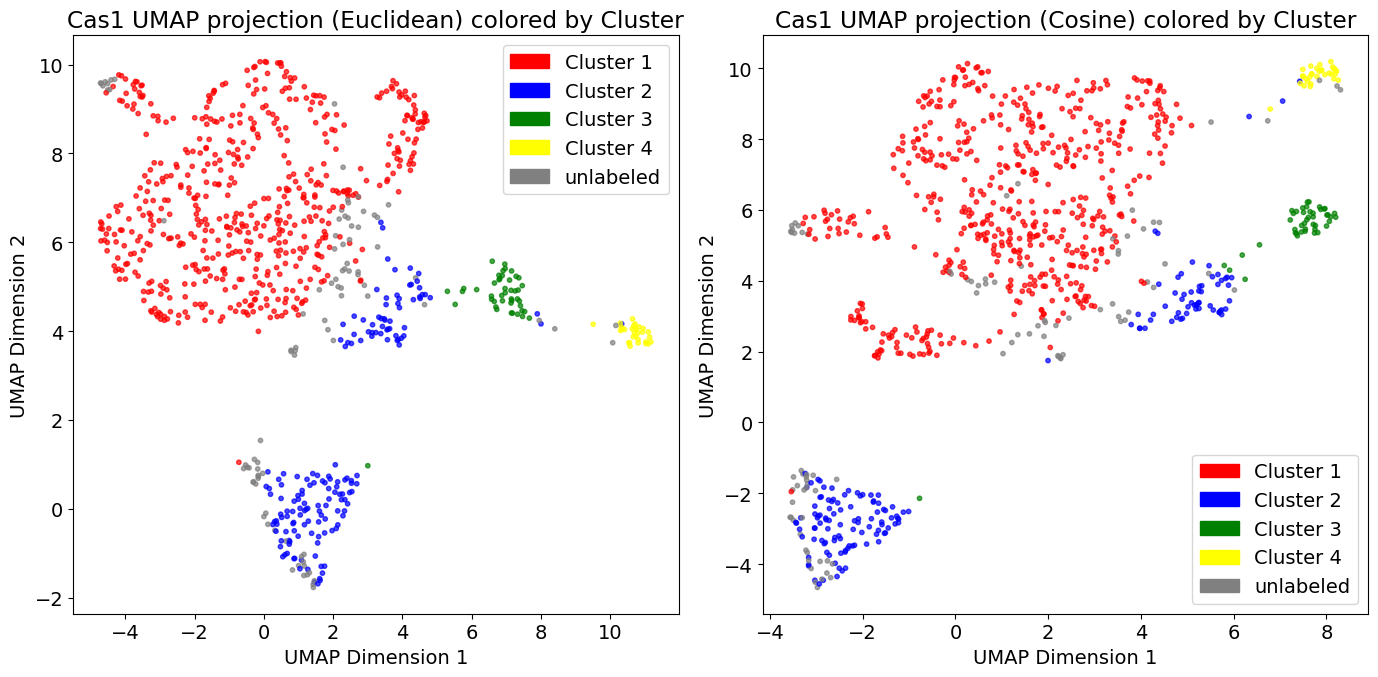

In [164]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define color map for clusters
cluster_colors = {'0': 'gray', '1': 'red', '2': 'blue','3':'green','4': 'yellow'}  # Adjust colors as needed

# Map the 'Cluster' column to colors
colors_euc = umap_embedding_cas1_euc_df['Cluster'].map(cluster_colors)
colors_cos = umap_embedding_cas1_cos_df['Cluster'].map(cluster_colors)

# Create legend handles
legend_handles = [
    mpatches.Patch(color='red', label='Cluster 1'),
    mpatches.Patch(color='blue', label='Cluster 2'),
    mpatches.Patch(color='green', label='Cluster 3'),
    mpatches.Patch(color='yellow', label='Cluster 4'),

    
    mpatches.Patch(color='gray', label='unlabeled')
]

# Create a figure with 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(14, 7))  # Adjust the figsize as needed

# Plotting the UMAP embedding based on Euclidean distance (left)
ax[0].scatter(umap_embedding_cas1_euc_df['x'], umap_embedding_cas1_euc_df['y'], 
              c=colors_euc, s=10, alpha=0.7)
ax[0].set_title('Cas1 UMAP projection (Euclidean) colored by Cluster')
ax[0].set_xlabel('UMAP Dimension 1')
ax[0].set_ylabel('UMAP Dimension 2')
ax[0].legend(handles=legend_handles)  # Add the legend here

# Plotting the UMAP embedding based on Cosine similarity (right)
ax[1].scatter(umap_embedding_cas1_cos_df['x'], umap_embedding_cas1_cos_df['y'], 
              c=colors_cos, s=10, alpha=0.7)
ax[1].set_title('Cas1 UMAP projection (Cosine) colored by Cluster')
ax[1].set_xlabel('UMAP Dimension 1')
ax[1].set_ylabel('UMAP Dimension 2')
ax[1].legend(handles=legend_handles)  # Add the legend here

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


Cas2

In [165]:
umap_config_euc = {
        'n_neighbors': 15,
        'n_components': 2,
        'metric': 'euclidean',
        'min_dist': 0.3,
        'local_connectivity': 1,
        'random_state':42
    }

    # Configure UMAP parameters for Cosine distance
umap_config_cos = {
    'n_neighbors': 15,
    'n_components': 2,
    'metric': 'cosine',
    'min_dist': 0.3,
    'local_connectivity': 1,
    'random_state':42
}
#get only cas1
interpro_cas2 = interpro_cas[interpro_cas['Signature description'] == 'CRISPR associated protein Cas2'].reset_index(drop=True)
interpro_cas2_embedding, interpro_cas2_labels = np.vstack(interpro_cas2.esm_embedding.values),np.vstack(interpro_cas2.loc[:,'Signature description'].values)
umap_embedding_cas2_euc = get_umap_embeddings(interpro_cas2_embedding,umap_config_euc)
umap_embedding_cas2_cos = get_umap_embeddings(interpro_cas2_embedding,umap_config_cos)



c:\Users\13330\.conda\envs\Shenzhen_GLM\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\13330\.conda\envs\Shenzhen_GLM\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


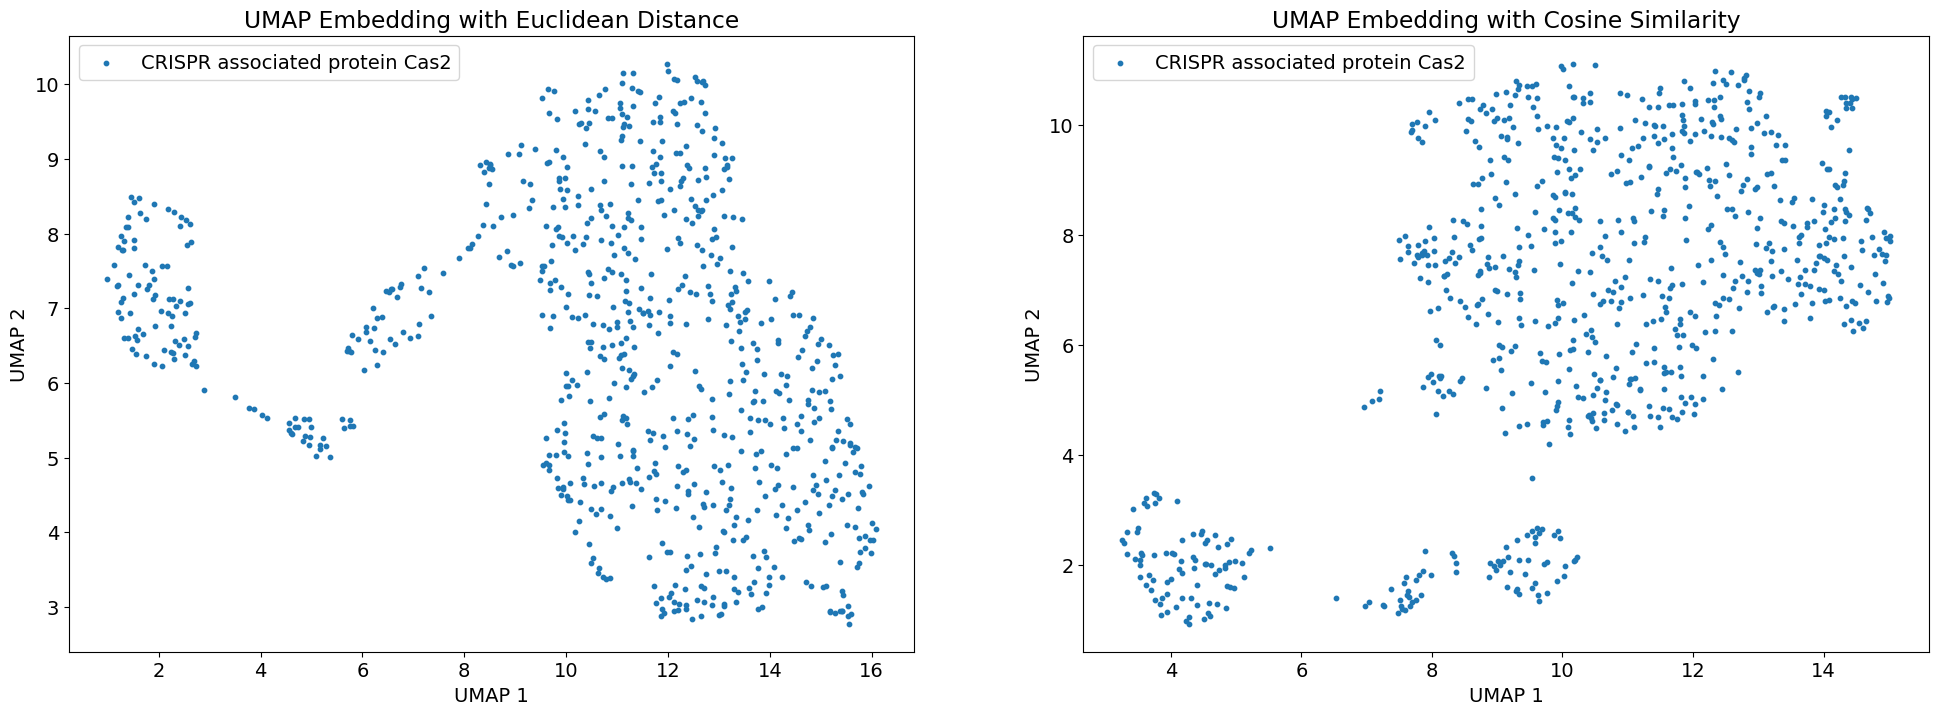

In [166]:
umap_embedding_cas2_euc_df = creat_cosomo_embedding(umap_embedding_cas2_euc,interpro_cas2_labels)
umap_embedding_cas2_cos_df = creat_cosomo_embedding(umap_embedding_cas2_cos,interpro_cas2_labels)
plot_scatter_with_labels(umap_embedding_cas2_euc_df,umap_embedding_cas2_cos_df)

Add ids of subcluster and show them in different colors


In [175]:
#get sorted esm all by protein accession
# get ids of subcluster of cas1 from cosmograph
cas2_subcluster_1_ids = [
    2988, 3210, 4377, 4906, 4944, 6679, 15396, 20994, 23653, 28090, 
    28982, 30190, 36979, 40399, 58255, 67645, 82455, 86586, 87406, 
    88217, 91705, 100245, 111583, 121072
]

cas2_subcluster_2_ids =  [
    121, 2703, 3569, 8113, 9466, 14258, 15122, 15301, 16223, 17029, 17163, 17297, 
    18890, 19184, 19559, 20663, 22609, 22662, 24345, 24821, 26639, 31084, 33887, 
    35943, 38420, 38781, 39046, 39131, 40316, 40791, 41653, 42495, 42746, 42756, 
    43175, 44892, 45800, 48210, 49100, 49596, 51999, 56613, 56956, 57552, 58167, 
    58598, 59661, 60121, 60246, 61407, 61518, 62471, 66037, 67014, 78096, 81641, 
    83130, 84988, 85242, 85475, 85502, 85548, 86506, 89217, 91769, 92087, 95275, 
    98156, 100148, 103708, 103852, 104513, 105351, 106006, 107533, 109971, 112849, 
    114481, 120344, 121035, 121625, 122251, 122260, 124994, 125165, 127964,
    192, 310, 697, 1647, 1782, 1926, 1929, 2728, 2746, 3146, 3760, 4254, 4465, 4623, 4698, 4748, 4760, 4779, 4796, 
    4797, 4835, 4873, 5501, 5543, 6586, 6802, 6839, 7133, 7233, 7243, 7265, 7323, 7326, 7676, 7724, 8924, 9451, 
    9548, 9691, 12548, 12953, 12975, 12990, 13190, 13363, 13382, 13406, 13431, 13448, 13457, 13495, 13506, 13922, 
    14098, 15062, 15116, 15554, 16047, 17411, 17642, 17977, 18396, 18466, 18581, 18802, 18807, 19009, 19173, 20290, 
    20366, 20651, 20655, 20776, 21074, 21078, 21106, 21282, 21394, 21518, 21631, 21645, 22037, 22341, 23086, 23099, 
    23219, 23293, 23960, 24128, 24188, 24545, 24571, 24597, 24786, 25215, 26378, 26492, 26802, 26917, 27410, 27806, 
    28338, 28446, 28712, 28777, 28853, 29062, 29519, 30525, 30738, 30752, 31061, 31404, 31470, 31591, 31592, 31594, 
    31634, 31740, 31768, 31782, 31996, 32264, 32301, 32364, 32903, 34994, 35622, 35639, 35641, 36070, 36728, 37090, 
    37235, 37332, 37603, 37644, 37798, 38223, 38260, 38342, 38350, 38560, 38598, 38697, 38970, 39049, 39128, 39194, 
    39359, 39433, 39535, 39583, 39622, 39688, 39929, 40064, 40193, 40227, 40436, 40555, 40975, 40984, 41157, 41178, 
    41272, 41277, 41340, 41843, 42247, 42302, 42328, 42340, 42389, 42415, 42630, 42813, 42847, 42926, 42940, 43029, 
    43044, 43169, 43530, 43535, 43544, 43711, 43797, 43888, 43973, 43980
]

# cas2_subcluster_3_ids = [
#     192, 310, 697, 1647, 1782, 1926, 1929, 2728, 2746, 3146, 3760, 4254, 4465, 4623, 4698, 4748, 4760, 4779, 4796, 
#     4797, 4835, 4873, 5501, 5543, 6586, 6802, 6839, 7133, 7233, 7243, 7265, 7323, 7326, 7676, 7724, 8924, 9451, 
#     9548, 9691, 12548, 12953, 12975, 12990, 13190, 13363, 13382, 13406, 13431, 13448, 13457, 13495, 13506, 13922, 
#     14098, 15062, 15116, 15554, 16047, 17411, 17642, 17977, 18396, 18466, 18581, 18802, 18807, 19009, 19173, 20290, 
#     20366, 20651, 20655, 20776, 21074, 21078, 21106, 21282, 21394, 21518, 21631, 21645, 22037, 22341, 23086, 23099, 
#     23219, 23293, 23960, 24128, 24188, 24545, 24571, 24597, 24786, 25215, 26378, 26492, 26802, 26917, 27410, 27806, 
#     28338, 28446, 28712, 28777, 28853, 29062, 29519, 30525, 30738, 30752, 31061, 31404, 31470, 31591, 31592, 31594, 
#     31634, 31740, 31768, 31782, 31996, 32264, 32301, 32364, 32903, 34994, 35622, 35639, 35641, 36070, 36728, 37090, 
#     37235, 37332, 37603, 37644, 37798, 38223, 38260, 38342, 38350, 38560, 38598, 38697, 38970, 39049, 39128, 39194, 
#     39359, 39433, 39535, 39583, 39622, 39688, 39929, 40064, 40193, 40227, 40436, 40555, 40975, 40984, 41157, 41178, 
#     41272, 41277, 41340, 41843, 42247, 42302, 42328, 42340, 42389, 42415, 42630, 42813, 42847, 42926, 42940, 43029, 
#     43044, 43169, 43530, 43535, 43544, 43711, 43797, 43888, 43973, 43980]




cas2_subcluster_1_protein_accessions = esm_all_df.loc[cas2_subcluster_1_ids, 'Protein accession'].values
cas2_subcluster_2_protein_accessions = esm_all_df.loc[cas2_subcluster_2_ids, 'Protein accession'].values
cas2_subcluster_3_protein_accessions = esm_all_df.loc[cas2_subcluster_3_ids, 'Protein accession'].values


interpro_cas2['Cluster'] = interpro_cas2.apply(lambda x: '1' if x['Protein accession'] in cas2_subcluster_1_protein_accessions 
                                             else '2' if x['Protein accession'] in cas2_subcluster_2_protein_accessions
                                             #else '3' if x['Protein accession'] in cas2_subcluster_3_protein_accessions
                                             else '0', axis=1)

umap_embedding_cas2_euc_df['Cluster'] = interpro_cas2['Cluster']
umap_embedding_cas2_cos_df['Cluster'] = interpro_cas2['Cluster']

add these in umap plot

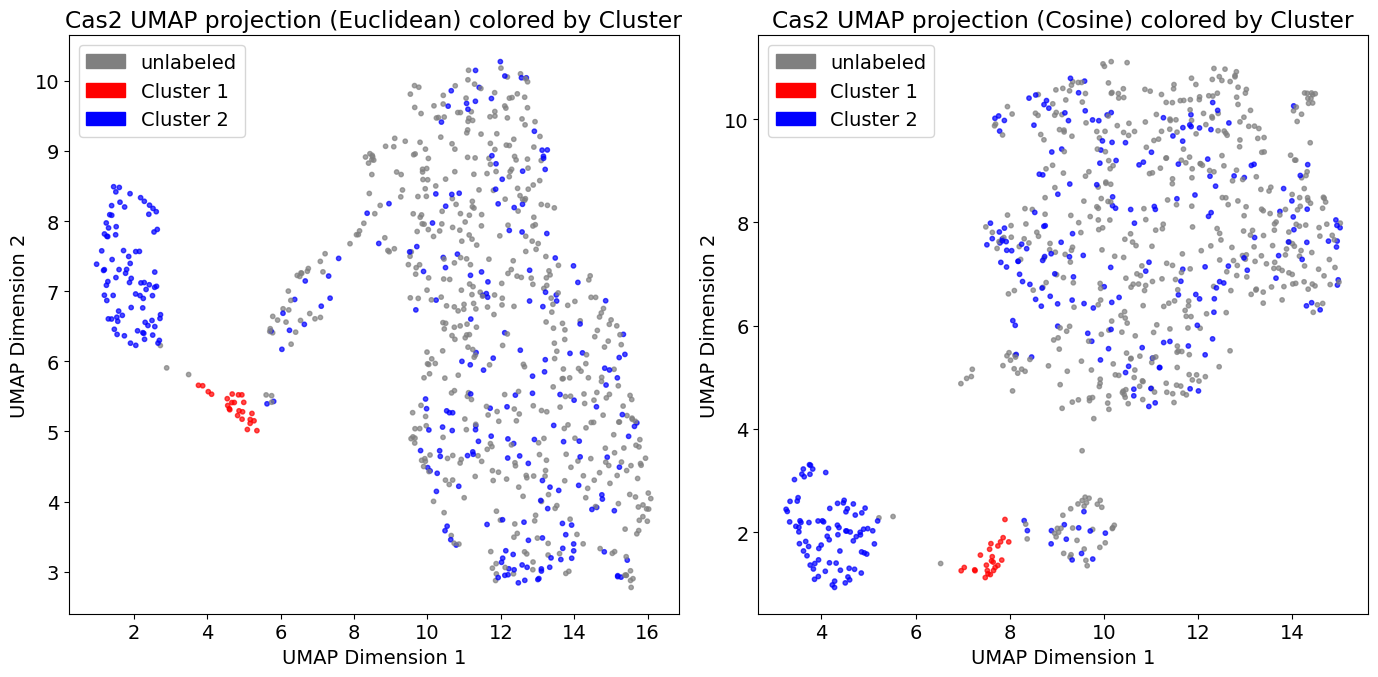

In [178]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define color map for clusters
cluster_colors = {'0':'gray','1': 'red', '2': 'blue'}  # Adjust colors as needed

# Map the 'Cluster' column to colors
colors_euc = umap_embedding_cas2_euc_df['Cluster'].map(cluster_colors)
colors_cos = umap_embedding_cas2_cos_df['Cluster'].map(cluster_colors)

# Create legend handles
legend_handles = [
    mpatches.Patch(color='gray', label='unlabeled'),
    mpatches.Patch(color='red', label='Cluster 1'),
    mpatches.Patch(color='blue', label='Cluster 2'),
    #mpatches.Patch(color='green', label='Cluster 3')
]

# Create a figure with 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(14, 7))  # Adjust the figsize as needed

# Plotting the UMAP embedding based on Euclidean distance (left)
ax[0].scatter(umap_embedding_cas2_euc_df['x'], umap_embedding_cas2_euc_df['y'], 
              c=colors_euc, s=10, alpha=0.7)
ax[0].set_title('Cas2 UMAP projection (Euclidean) colored by Cluster')
ax[0].set_xlabel('UMAP Dimension 1')
ax[0].set_ylabel('UMAP Dimension 2')
ax[0].legend(handles=legend_handles)  # Add the legend here

# Plotting the UMAP embedding based on Cosine similarity (right)
ax[1].scatter(umap_embedding_cas2_cos_df['x'], umap_embedding_cas2_cos_df['y'], 
              c=colors_cos, s=10, alpha=0.7)
ax[1].set_title('Cas2 UMAP projection (Cosine) colored by Cluster')
ax[1].set_xlabel('UMAP Dimension 1')
ax[1].set_ylabel('UMAP Dimension 2')
ax[1].legend(handles=legend_handles)  # Add the legend here

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


Does the seqs in mixed cluster include multiple labels? 

In [11]:
idx = umap_config_euc_df[(umap_config_euc_df.x > 10) & (umap_config_euc_df.x < 16)].index
interpro_cas.iloc[idx,]
duplicate_sequences = interpro_cas_all[interpro_cas_all.duplicated('Protein accession', keep=False)]


NameError: name 'umap_config_euc_df' is not defined

In [164]:
set_duplicated = set(duplicate_sequences.loc[:,'Protein accession'])
set_odd_cluster = set(interpro_cas.iloc[idx,].loc[:,'Protein accession'])

set_duplicated.intersection(set_odd_cluster)

{'IMG_3300010960&&Ga0137307_100805&&29133_29742_1'}

## Subtask 2.2Number of multiple labels

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming total_interpro_df is already defined
total_interpro_pfam = total_interpro_df[total_interpro_df['Analysis'] == 'Pfam']
# Count the number of labels for each sequence
label_counts = total_interpro_pfam['Protein accession'].value_counts()

# Filter sequences with more than one label
multiple_label_counts = label_counts[label_counts > 1]

# Draw histogram plot distribution of multiple label counts with log scale
plt.figure(figsize=(10, 6))
plt.hist(multiple_label_counts, bins=range(2, multiple_label_counts.max() + 2), edgecolor='black', log=True)
plt.title('Distribution of Sequences with Multiple annotations')
plt.xlabel('Number of annotations')
plt.ylabel('Frequency')

# Set x-axis ticks with an interval of 5
plt.xticks(range(2, multiple_label_counts.max() + 2, 5))

plt.show()

NameError: name 'total_interpro_df' is not defined

## Does the embedding distribute randomly?

Frist check label distribution

distribution of each label, found >5000 labels only occure once


Most labels only appear once!

C:\Users\13330\AppData\Local\Temp\ipykernel_30872\3205448212.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




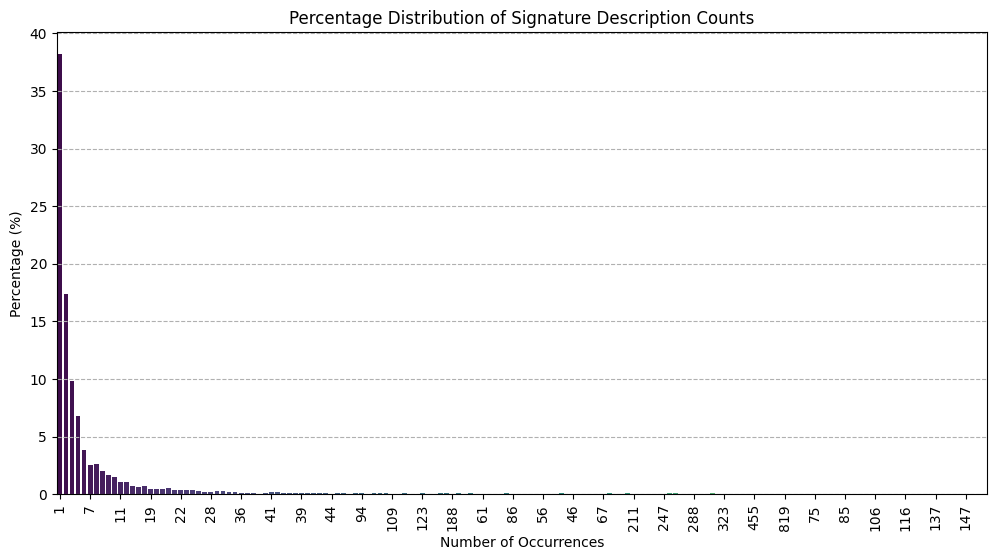

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming total_interpro_pfam is your DataFrame
# Get the counts of each Signature description
signature_counts = total_interpro_pfam['Signature description'].value_counts()

# Get the counts of the occurrence frequencies
occurrence_counts = signature_counts.value_counts()

# Convert the counts to percentages
percentage_counts = (occurrence_counts / occurrence_counts.sum()) * 100

# Plot the distribution using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=percentage_counts.index, y=percentage_counts.values, palette="viridis")
plt.title('Percentage Distribution of Signature Description Counts')
plt.xlabel('Number of Occurrences')
plt.ylabel('Percentage (%)')

# Show only every 5th label on the x-axis
plt.xticks(ticks=range(0, len(percentage_counts.index), 5), 
           labels=percentage_counts.index[::5], 
           rotation=90)

plt.grid(True, axis='y', linestyle='--')
plt.show()


In [10]:
# Define the threshold
number_threshold = 50

# Filter signature_counts to keep only labels with occurrence >= threshold
filtered_signature_counts = signature_counts[signature_counts >= number_threshold]
#plot
import plotly
import plotly.express as px

# Define the threshold
number_threshold = 50

# Filter signature_counts to keep only labels with occurrence >= threshold
filtered_signature_counts = signature_counts[signature_counts >= number_threshold]

# Create a DataFrame for plotting
df = filtered_signature_counts.reset_index()
df.columns = ['Label', 'Count']

# Plot using Plotly
fig = px.bar(df, x='Label', y='Count', title='Label Occurrences', labels={'Label': 'Label', 'Count': 'Occurrences'})

# Show the plot
fig.show()

In [11]:


# Define the threshold
number_threshold = 50

# Filter signature_counts to keep only labels with occurrence >= threshold
filtered_signature_counts = signature_counts[signature_counts >= number_threshold]

# Create a DataFrame for plotting
df = filtered_signature_counts.reset_index()
df.columns = ['Label', 'Count']

# Plot using Plotly
fig = px.bar(df, x='Label', y='Count', title='Label Occurrences', labels={'Label': 'Label', 'Count': 'Occurrences'})

# Show the plot
fig.show()

## Subtask2.3Pair-wise within group distance


First get seqs info with single label 

In [316]:
#get interpro of pfam
total_interpro_pfam = total_interpro_df[total_interpro_df['Analysis'] == 'Pfam']
#embedding df
#umap_esm_euc_embedding = UmapEmbedding(work_path).esm3_umap_euc ################need to solve
umap_esm_euc_embedding_df = pd.read_csv('./Output/ESM/ESM_Embedding_Cosmograph/esm_3_umap_all_embedding_euclidean_top_10_pfam.csv')
# add Protein accession
umap_esm_euc_embedding_df['Protein accession'] = sorted(esm_embedding_accession)
#only keep protein id with single pfam label
single_pfam_label_interpro_df = total_interpro_pfam.groupby('Protein accession').filter(lambda x: len(x) == 1).loc[:,['Protein accession','Signature description']]
umap_esm_euc_single_pfam_label = pd.merge(umap_esm_euc_embedding_df, single_pfam_label_interpro_df, 
                     on='Protein accession', how='inner')
multiple_pfam_label_interpro_df = total_interpro_pfam.groupby('Protein accession').filter(lambda x: len(x) > 1).loc[:,['Protein accession','Signature description']]

umap_esm_euc_multiple_pfam_label = pd.merge(umap_esm_euc_embedding_df, multiple_pfam_label_interpro_df, 
                     on='Protein accession', how='inner')

Keep labels that are larger than the threshold

In [318]:
#should filter by whole dataset, as some labels might only occur in multiple labels.
threshold = 200
filter_labels = total_interpro_pfam.groupby('Signature description').filter(lambda x: len(x) >= threshold)
print('Total number of labels that are largerthan the threshold:',len(filter_labels['Signature description'].unique()))
filtered_signature_descriptions = filter_labels['Signature description'].unique()
single_filter_pfam_label_interpro_df = single_pfam_label_interpro_df[single_pfam_label_interpro_df['Signature description'].isin(filtered_signature_descriptions)]

Total number of labels that are largerthan the threshold: 35


C:\Users\13330\AppData\Local\Temp\ipykernel_30872\950728109.py:66: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\13330\AppData\Local\Temp\ipykernel_30872\950728109.py:75: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




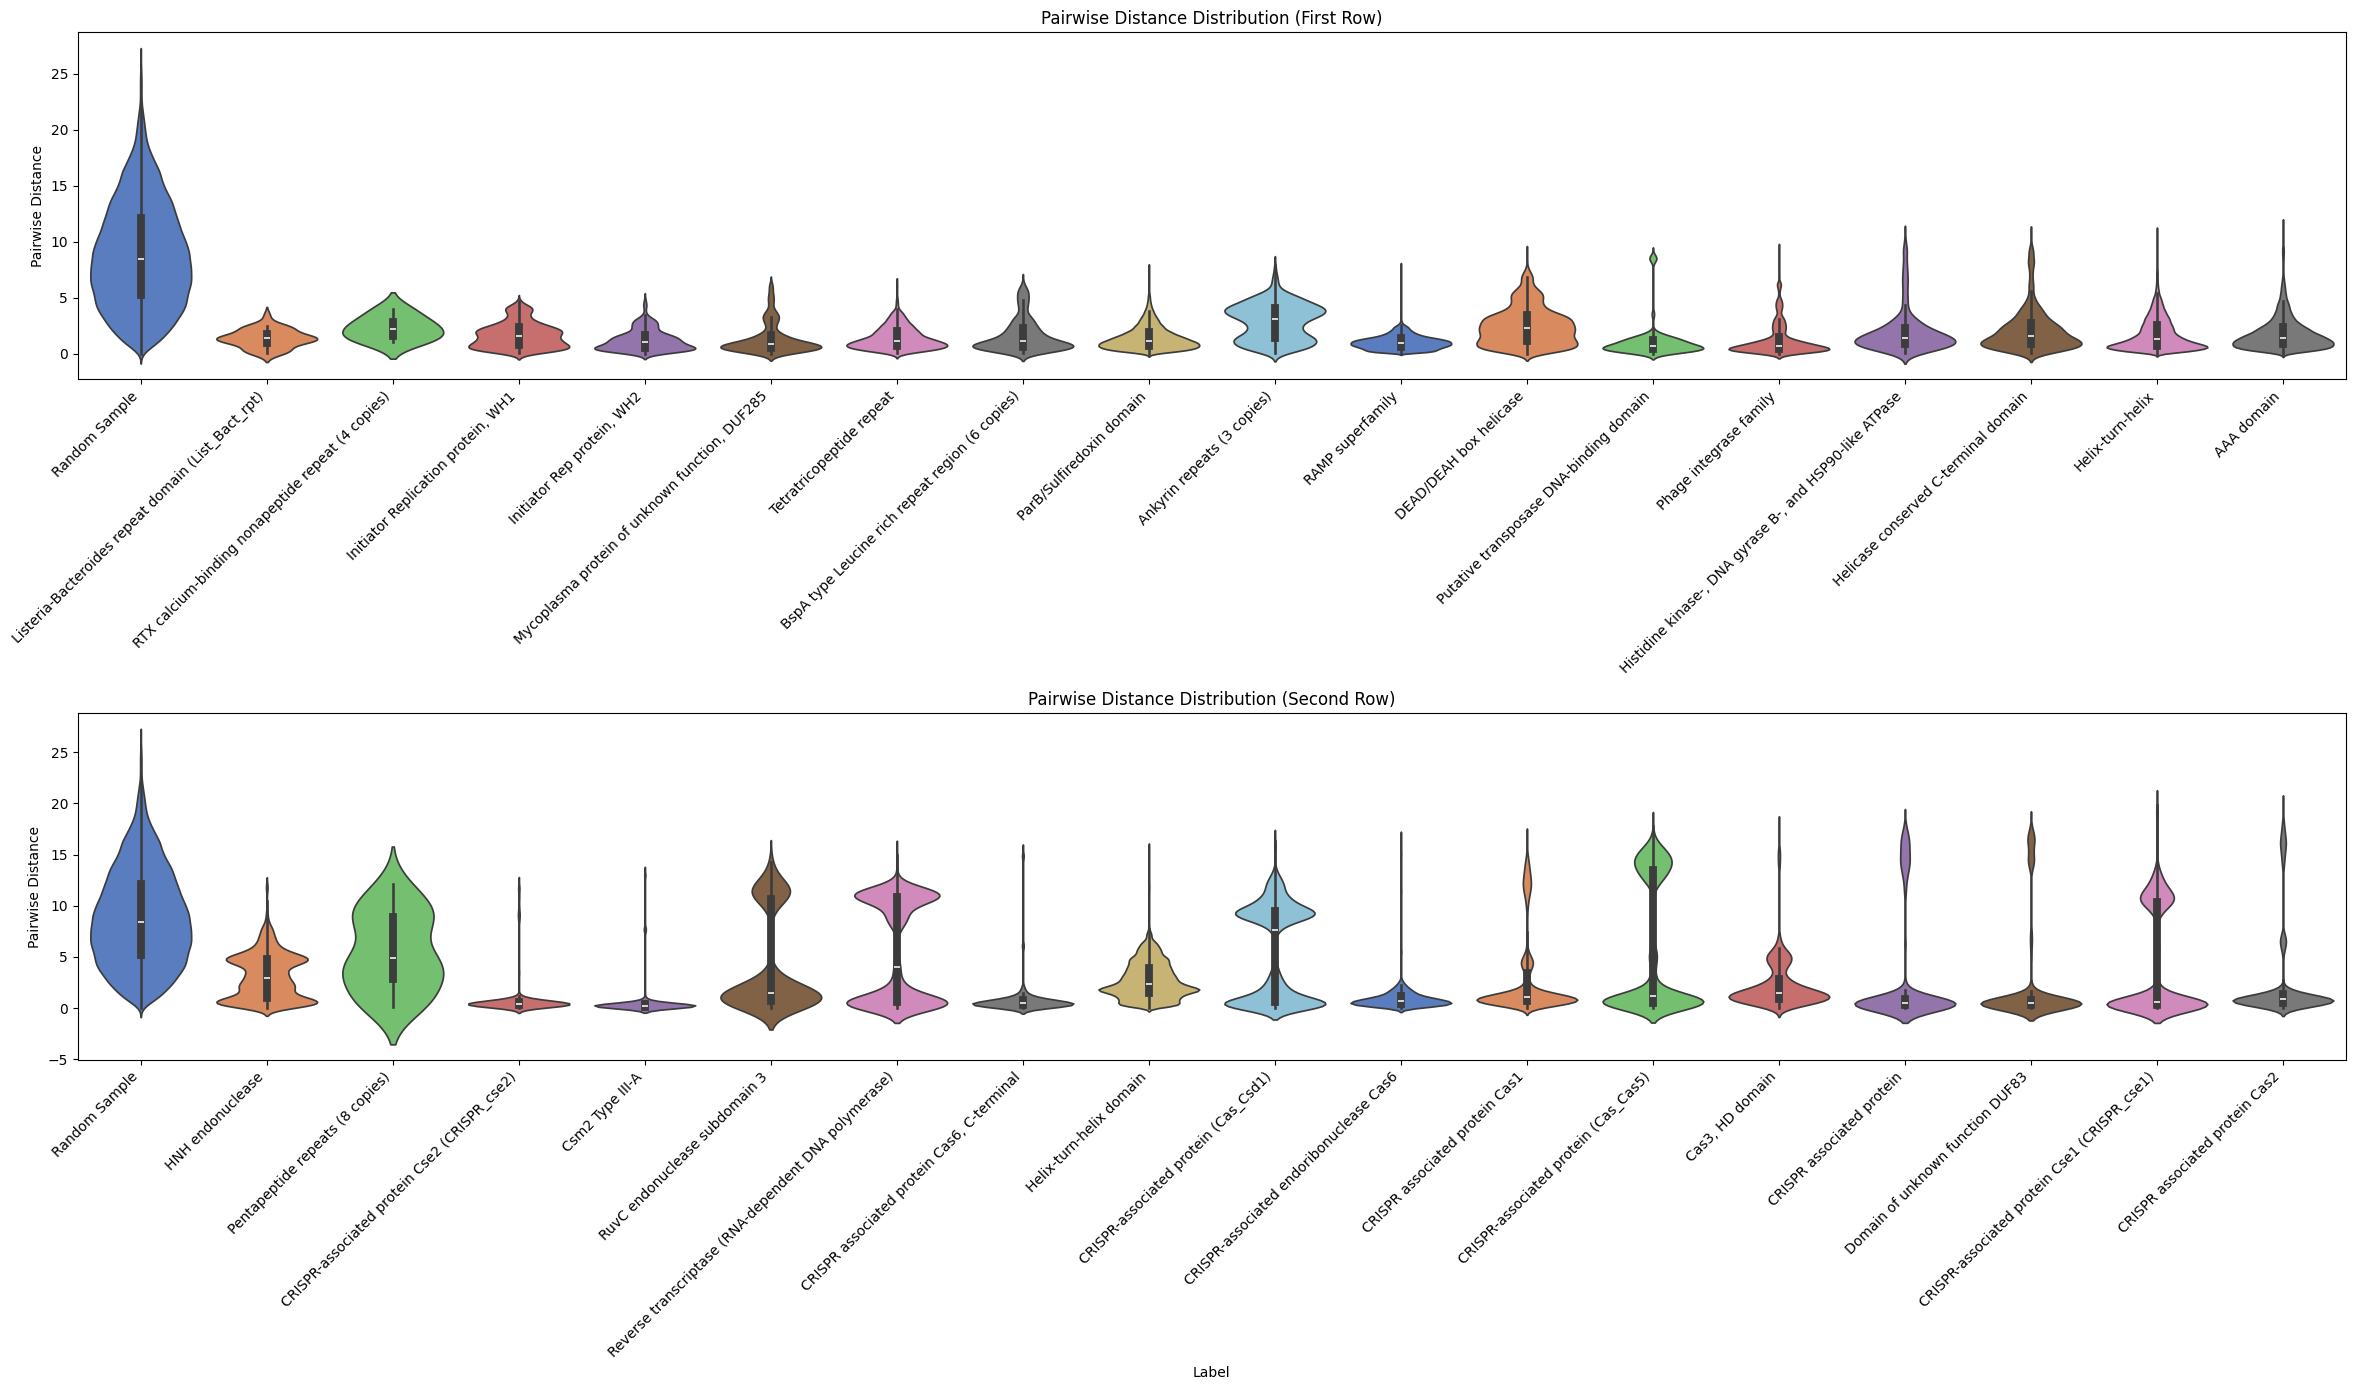

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Function to calculate pairwise distances
def calculate_pair_wise_distance(group):
    """
    Args:
    - group: DataFrame containing 'x', 'y' columns
    
    Returns:
    - distance_matrix: Squareform matrix of pairwise distances
    """
    embeddings = group[['x', 'y']].values
    pairwise_distances = pdist(embeddings, metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    return distance_matrix

# Randomly sample 500 points from the dataset
sampled_data = umap_df_euc.sample(n=500, random_state=42)

# Calculate pairwise distances for the random sample
distance_matrix = calculate_pair_wise_distance(sampled_data)

# Extract the upper triangular matrix (excluding the diagonal)
upper_triangle_values = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]

# Store the distance values in a DataFrame with a 'Random Sample' label
baseline_data = pd.DataFrame({'Distance': upper_triangle_values, 'Label': 'Random Sample'})

# Group by label and calculate pairwise distances for each group
test_set = umap_esm_euc_filter_single_pfam_label
grouped = test_set.groupby('Signature description')

# Collect all upper triangle distance values and add a label for each group
data = []
max_ranges = {}

for label, group in grouped:
    distance_matrix = calculate_pair_wise_distance(group)
    # Extract the upper triangular matrix (excluding the diagonal)
    upper_triangle_values = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    if len(upper_triangle_values) > 0:  # Ensure the data is not empty
        data.append(pd.DataFrame({'Distance': upper_triangle_values, 'Label': label}))
        max_ranges[label] = upper_triangle_values.max()

# Combine all data into a single DataFrame
plot_data = pd.concat(data)

# Add the random sample data to the plot data
plot_data = pd.concat([baseline_data, plot_data])

# Sort labels by maximum distance value
sorted_labels = sorted(max_ranges.keys(), key=lambda x: max_ranges[x])

# Split sorted labels into two groups and add 'Random Sample' at the beginning of each
labels_group_1 = ['Random Sample'] + sorted_labels[:len(sorted_labels)//2]
labels_group_2 = ['Random Sample'] + sorted_labels[len(sorted_labels)//2:]

# Create the plot with two rows
fig, axes = plt.subplots(2, 1, figsize=(24, 14))  # Increased figure size for better spacing

# First row: Plot the first group of labels
sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_1)], 
               order=labels_group_1, inner="box", palette="muted", ax=axes[0])
axes[0].set_title("Pairwise Distance Distribution (First Row)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Pairwise Distance")
axes[0].set_xticks(np.arange(len(labels_group_1)))  # Ensure correct number of ticks
axes[0].set_xticklabels(labels_group_1, rotation=45, ha='right')  # Correct rotation and alignment

# Second row: Plot the second group of labels
sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_2)], 
               order=labels_group_2, inner="box", palette="muted", ax=axes[1])
axes[1].set_title("Pairwise Distance Distribution (Second Row)")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Pairwise Distance")
axes[1].set_xticks(np.arange(len(labels_group_2)))  # Ensure correct number of ticks
axes[1].set_xticklabels(labels_group_2, rotation=45, ha='right')  # Correct rotation and alignment

# Adjust layout
plt.tight_layout()
plt.show()


Draw within group pair wise distances

In [ ]:
single_filter_pfam_Cas_interpro_df = single_filter_pfam_label_interpro_df[single_filter_pfam_label_interpro_df['Signature description'].isin(['CRISPR associated protein Cas1','CRISPR associated protein Cas2'])]
# Perform the merge operation on 'Protein accession'
umap_esm_euc_single_filter_pfam_Cas_label = pd.merge(single_filter_pfam_Cas_interpro_df[['Protein accession','Signature description']],
                     umap_esm_euc_single_pfam_label[['Protein accession', 'x', 'y']],
                     how='inner', 
                     on='Protein accession')

grouped = umap_esm_euc_single_filter_pfam_Cas_label.groupby('Signature description')

# Collect all upper triangle distance values and add a label for each group
data = []
max_ranges = {}

for label, group in grouped:
    distance_matrix = calculate_pair_wise_distance(group)
    # Extract the upper triangular matrix (excluding the diagonal)
    upper_triangle_values = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    if len(upper_triangle_values) > 0:  # Ensure the data is not empty
        data.append(pd.DataFrame({'Distance': upper_triangle_values, 'Label': label}))
        max_ranges[label] = upper_triangle_values.max()

# Combine all data into a single DataFrame
plot_data = pd.concat(data)

# Add the random sample data to the plot data
plot_data = pd.concat([baseline_data, plot_data])

# Sort labels by maximum distance value
sorted_labels = sorted(max_ranges.keys(), key=lambda x: max_ranges[x])

# Split sorted labels into two groups and add 'Random Sample' at the beginning of each
labels_group_1 = ['Random Sample'] + sorted_labels[:len(sorted_labels)//2]
labels_group_2 = ['Random Sample'] + sorted_labels[len(sorted_labels)//2:]

# Create the plot with two rows
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# First row: Plot the first group of labels
sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_1)], 
               order=labels_group_1, inner="box", palette="muted", ax=axes[0])
axes[0].set_title("Pairwise Distance Distribution (First Row)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Pairwise Distance")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Second row: Plot the second group of labels
sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_2)], 
               order=labels_group_2, inner="box", palette="muted", ax=axes[1])
axes[1].set_title("Pairwise Distance Distribution (Second Row)")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Pairwise Distance")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


<Figure size 1200x1000 with 0 Axes>

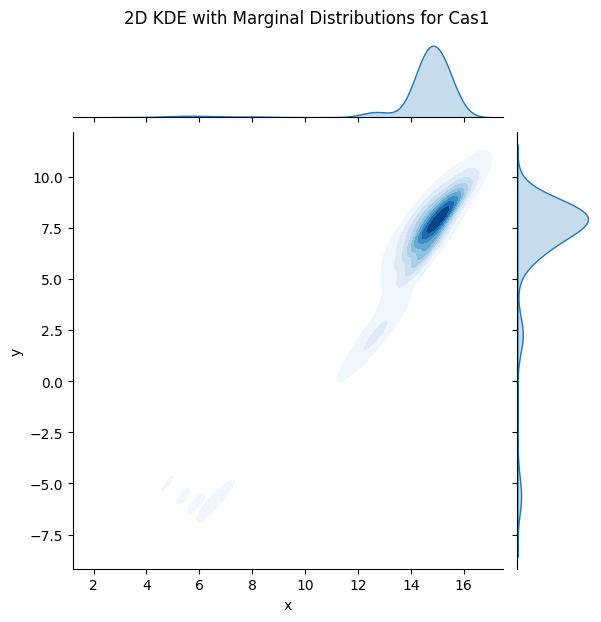

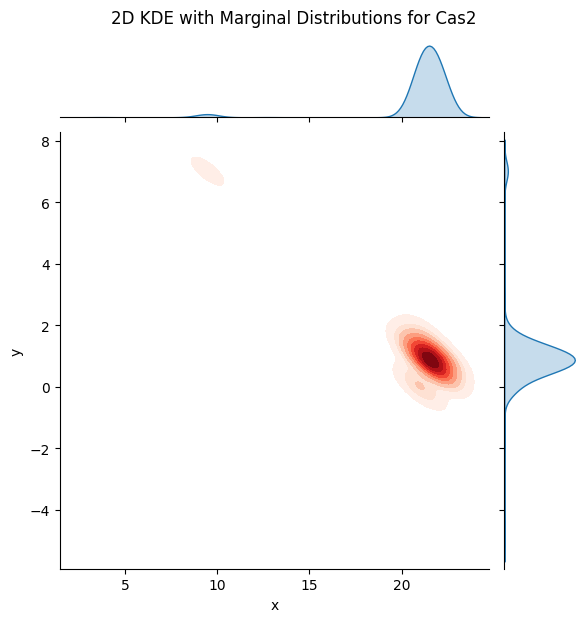

In [322]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is named 'umap_esm_euc_single_filter_pfam_Cas_label'
df = umap_esm_euc_single_filter_pfam_Cas_label

# Filter data for Cas1 and Cas2
cas1_df = df[df['Signature description'] == 'CRISPR associated protein Cas1']
cas2_df = df[df['Signature description'] == 'CRISPR associated protein Cas2']

# 2D KDE plot with marginal KDEs for Cas1
plt.figure(figsize=(12, 10))

g1 = sns.jointplot(
    x=cas1_df['x'], 
    y=cas1_df['y'], 
    kind="kde", 
    cmap="Blues", 
    fill=True, 
    bw_adjust=1,  # Adjust this parameter to control smoothness
    marginal_kws=dict(fill=True)  # Adds marginal KDEs
)
g1.fig.suptitle('2D KDE with Marginal Distributions for Cas1', y=1.03)

# 2D KDE plot with marginal KDEs for Cas2
g2 = sns.jointplot(
    x=cas2_df['x'], 
    y=cas2_df['y'], 
    kind="kde", 
    cmap="Reds", 
    fill=True, 
    bw_adjust=1,  # Adjust this parameter to control smoothness
    marginal_kws=dict(fill=True)  # Adds marginal KDEs
)
g2.fig.suptitle('2D KDE with Marginal Distributions for Cas2', y=1.03)

plt.show()


## Subtask2.4 Cas* proteins statistics


In [170]:
from Bio import SeqIO
import pandas as pd

In [171]:
environment_path = work_path.environment_path
fasta_folder = 'Data/'
fasta_file_path = search_csv_file(environment_path,fasta_folder,'total.fasta')
# Define lists to store sequence names and lengths
sequence_names = []
sequence_lengths = []

# Read the FASTA file
with open(fasta_file_path) as fasta_file:
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequence_names.append(record.id)  # Extract the sequence name
        sequence_lengths.append(len(record.seq))  # Extract the sequence length

# Create a DataFrame contain protein accession & length
fasta_all_df = pd.DataFrame({
    "Protein accession": sequence_names,
    "Length": sequence_lengths
})

total_interpro_pfam_folder = 'Shenzhen_GLM_Project/'
total_interpro_pfam_path = search_csv_file(environment_path,total_interpro_pfam_folder,'total_interpro_pfam.csv')

#read total_interpro_pfam
total_interpro_pfam_df = pd.read_csv(total_interpro_pfam_path)

umap_esm_euc_embedding_folder = 'Shenzhen_GLM_Project'
umap_esm_euc_embedding_path = search_csv_file(environment_path,umap_esm_euc_embedding_folder,'esm_3_umap_all_embedding_euclidean_top_10_pfam.csv')
umap_esm_cos_embedding_path = search_csv_file(environment_path,umap_esm_euc_embedding_folder,'esm_3_umap_all_embedding_cosine_top_10_pfam.csv')

umap_esm_euc_embedding_df, umap_esm_cos_embedding_df = pd.read_csv(umap_esm_euc_embedding_path),pd.read_csv(umap_esm_cos_embedding_path)
#add protein accession
umap_esm_euc_embedding_df['Protein accession'] = esm_all_df['Protein accession']
umap_esm_cos_embedding_df['Protein accession'] = esm_all_df['Protein accession']


extract Cas associated proteins

In [172]:
# Filter cas-associated proteins
cas_associated_proteins = total_interpro_pfam_df[total_interpro_pfam_df['Signature description'].str.contains('crispr[- ]associated protein', case=False, na=False)].loc[:, ['Protein accession', 'Signature description']]

# Merge cas proteins and umap embeddings
cas_associated_proteins_umap_embedding_df = pd.merge(cas_associated_proteins, umap_esm_euc_embedding_df, on='Protein accession')

# Drop same annotations within each protein accession
# Step 1: Drop duplicate 'Signature description' values within each 'Protein accession' group
cas_associated_proteins_umap_embedding_non_duplicated_df = cas_associated_proteins_umap_embedding_df.drop_duplicates(subset=['Protein accession', 'Signature description'])

# Step 2: (Optional) Reset the index if needed
cas_associated_proteins_umap_embedding_non_duplicated_df = cas_associated_proteins_umap_embedding_non_duplicated_df.reset_index(drop=True)

#add seq length for filtered proteins
cas_associated_proteins_umap_embedding_non_duplicated_df=pd.merge(cas_associated_proteins_umap_embedding_non_duplicated_df,fasta_all_df,on='Protein accession')

### Analysis
- Numbers of each Cas associated proteins
- Length of each Cas associated proteins
- Pari-wise distance of each Cas associated proteins

In [ ]:
#group by labels
cas_associated_proteins_group = cas_associated_proteins_umap_embedding_non_duplicated_df.groupby('Signature description')

cas_associated_proteins_nums = len(cas_associated_proteins_group)

#length distribution (using log10)
cas_associated_proteins_umap_embedding_non_duplicated_df

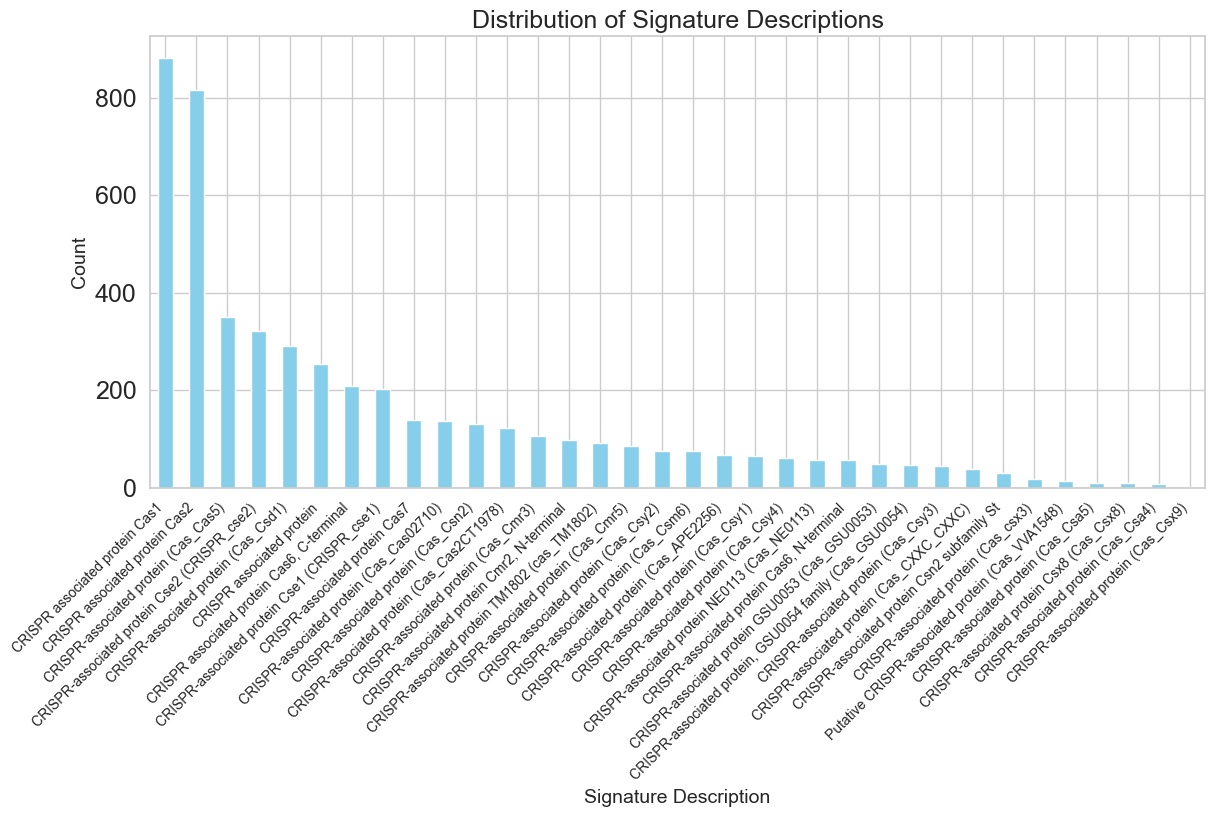

In [54]:
#distribut of each type
import matplotlib.pyplot as plt
import pandas as pd

# Count the occurrences of each 'Signature description' and sort by count in descending order
signature_counts = cas_associated_proteins_umap_embedding_non_duplicated_df['Signature description'].value_counts()

# Create a figure with a specified size
plt.figure(figsize=(12, 8))  # Adjust figure size for better clarity

# Plot a bar chart with the counts, sorted by frequency (from most to least)
signature_counts.plot(kind='bar', color='skyblue')

# Set title and axis labels
plt.title('Distribution of Signature Descriptions', fontsize=18)
plt.xlabel('Signature Description', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels to avoid overlapping and adjust the font size
plt.xticks(rotation=45, ha='right', fontsize=10)

# Adjust layout to prevent label overlap and improve spacing
plt.tight_layout()

# Display the plot
plt.show()

C:\Users\13330\AppData\Local\Temp\ipykernel_820\3132288145.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Signature description', y='Log10 Length',
C:\Users\13330\AppData\Local\Temp\ipykernel_820\3132288145.py:35: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Signature description', y='Log10 Length',
C:\Users\13330\AppData\Local\Temp\ipykernel_820\3132288145.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Signature description', y='Log10 Length',
C:\Users\13330\AppData\Local\Temp\ipykernel_820\3132288145.py:45: FutureWarning: 

The `scale` parameter has been

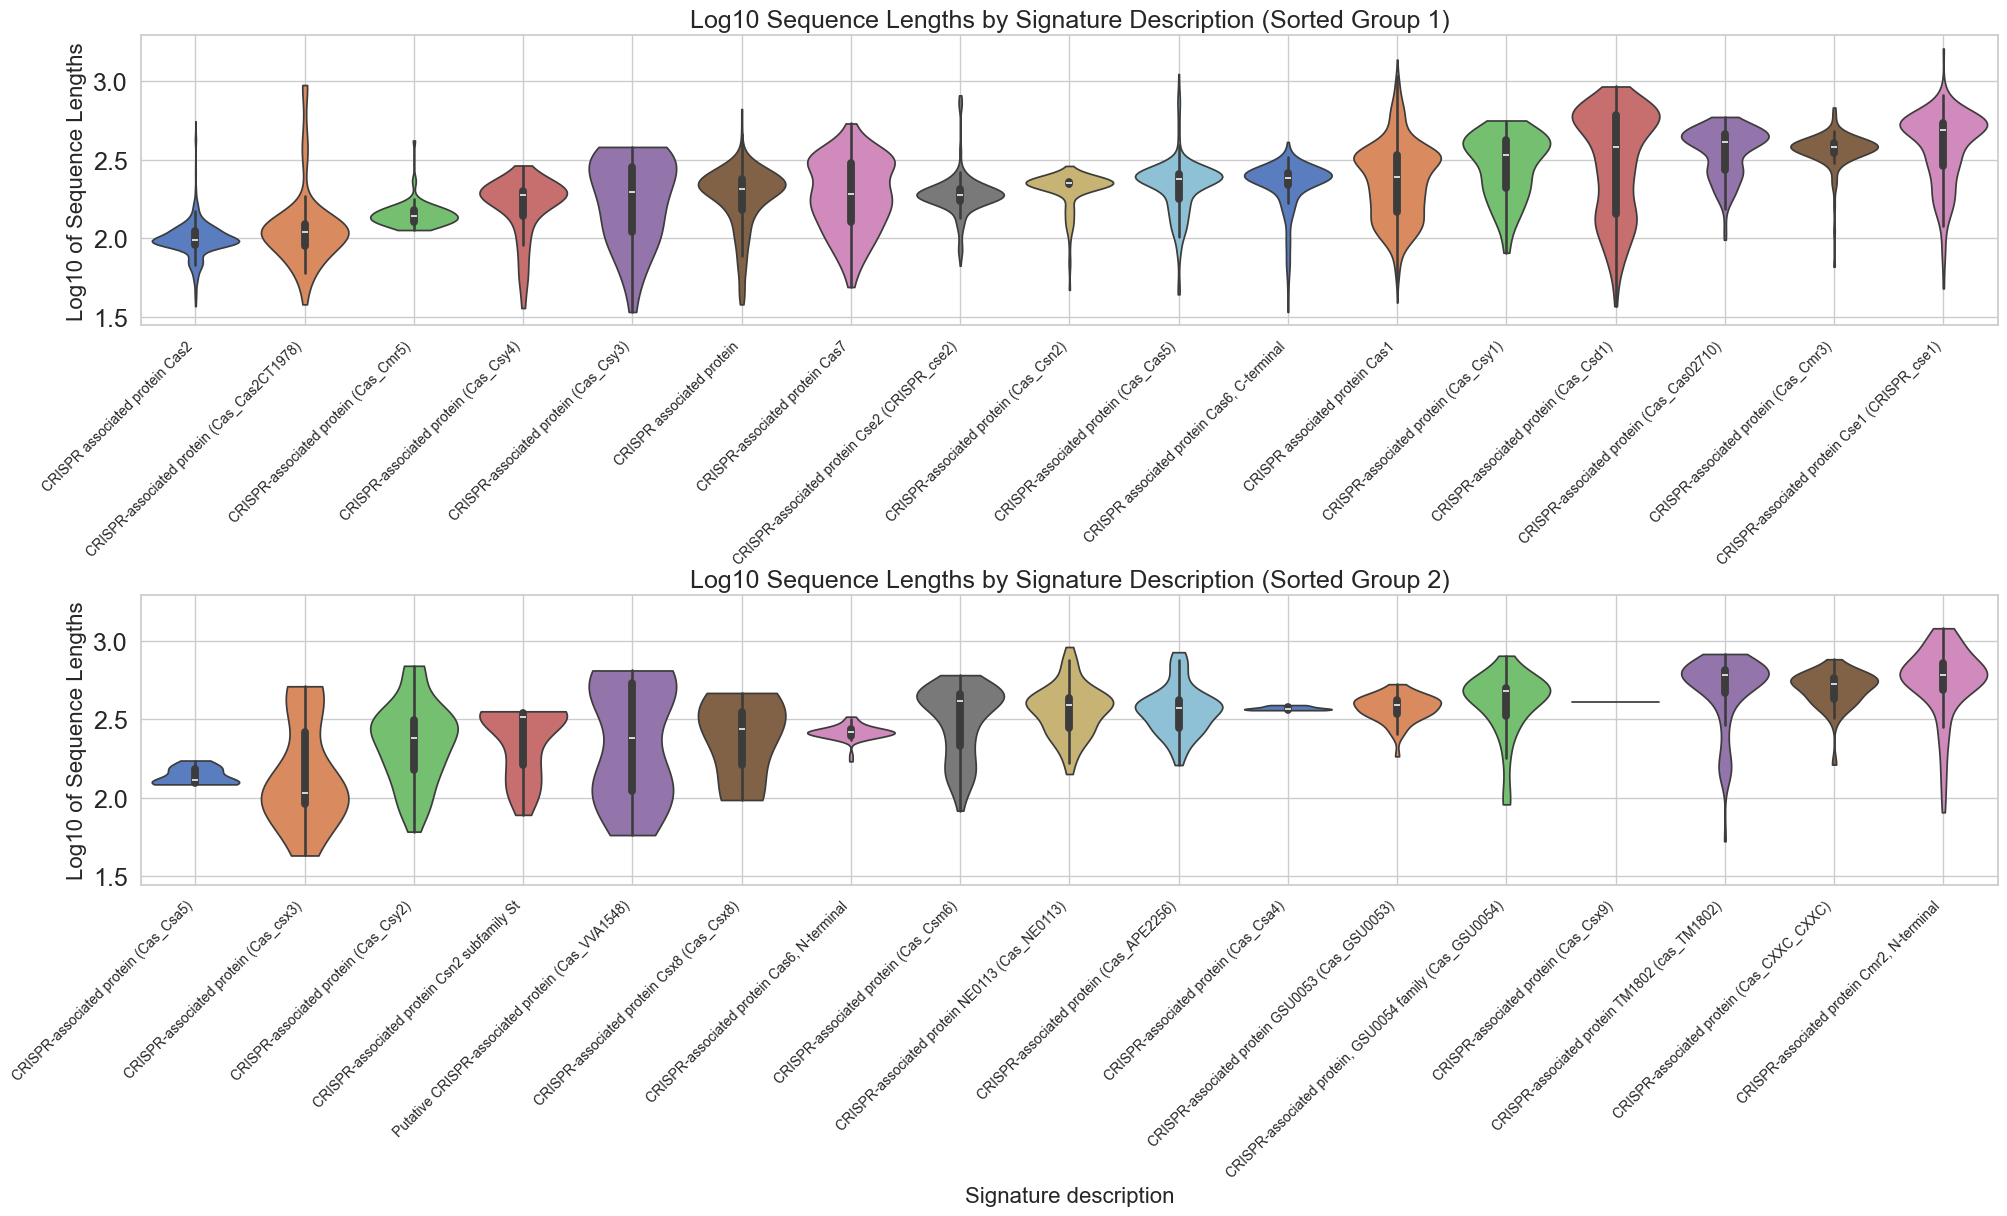

In [135]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the log10 of sequence lengths
cas_associated_proteins_umap_embedding_non_duplicated_df['Log10 Length'] = np.log10(cas_associated_proteins_umap_embedding_non_duplicated_df['Length'])

# Get unique labels for splitting
unique_labels = cas_associated_proteins_umap_embedding_non_duplicated_df['Signature description'].unique()

# Split the unique labels into two groups (roughly 50/50)
split_index = len(unique_labels) // 2
labels_group1 = unique_labels[:split_index]
labels_group2 = unique_labels[split_index:]

# Calculate the mean Log10 Length for each 'Signature description' in group 1 and group 2
mean_lengths_group1 = cas_associated_proteins_umap_embedding_non_duplicated_df[cas_associated_proteins_umap_embedding_non_duplicated_df['Signature description'].isin(labels_group1)].groupby('Signature description')['Log10 Length'].mean().sort_values()
mean_lengths_group2 = cas_associated_proteins_umap_embedding_non_duplicated_df[cas_associated_proteins_umap_embedding_non_duplicated_df['Signature description'].isin(labels_group2)].groupby('Signature description')['Log10 Length'].mean().sort_values()

# Sort the labels based on the mean Log10 Length for each group
sorted_labels_group1 = mean_lengths_group1.index
sorted_labels_group2 = mean_lengths_group2.index

# To align the x-ticks, we need the same number of x-ticks in both subplots
# Pad the shorter group with empty strings for alignment
max_len = max(len(sorted_labels_group1), len(sorted_labels_group2))
padded_labels_group1 = list(sorted_labels_group1) + [''] * (max_len - len(sorted_labels_group1))
padded_labels_group2 = list(sorted_labels_group2) + [''] * (max_len - len(sorted_labels_group2))

# Create a figure with two subplots and increase the size
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharey=True)  # Share y-axis to keep the same scale

# Plot for the first group of labels (sorted by mean log10 length)
sns.violinplot(x='Signature description', y='Log10 Length', 
               data=cas_associated_proteins_umap_embedding_non_duplicated_df[cas_associated_proteins_umap_embedding_non_duplicated_df['Signature description'].isin(sorted_labels_group1)],
               ax=ax1, inner="box", palette="muted", scale="width", cut=0, order=sorted_labels_group1)  # Violin plot for distribution
ax1.set_title('Log10 Sequence Lengths by Signature Description (Sorted Group 1)')
ax1.set_xlabel('')
ax1.set_ylabel('Log10 of Sequence Lengths')
ax1.tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x-axis labels only for Group 1
ax1.grid(True)

# Plot for the second group of labels (sorted by mean log10 length)
sns.violinplot(x='Signature description', y='Log10 Length', 
               data=cas_associated_proteins_umap_embedding_non_duplicated_df[cas_associated_proteins_umap_embedding_non_duplicated_df['Signature description'].isin(sorted_labels_group2)],
               ax=ax2, inner="box", palette="muted", scale="width", cut=0, order=sorted_labels_group2)  # Violin plot for distribution
ax2.set_title('Log10 Sequence Lengths by Signature Description (Sorted Group 2)')
ax2.set_xlabel('Signature description')
ax2.set_ylabel('Log10 of Sequence Lengths')
ax2.tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x-axis labels only for Group 2
ax2.grid(True)

# Align the x-axis ticks for both subplots using the padded labels
ax1.set_xticks(np.arange(max_len))
ax1.set_xticklabels(padded_labels_group1, rotation=45, ha="right")

ax2.set_xticks(np.arange(max_len))
ax2.set_xticklabels(padded_labels_group2, rotation=45, ha="right")

# Adjust layout for better spacing and alignment
plt.tight_layout()

# Show the plots
plt.show()


Pair-wise distance

C:\Users\13330\AppData\Local\Temp\ipykernel_820\516765085.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_1)],
C:\Users\13330\AppData\Local\Temp\ipykernel_820\516765085.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_2)],


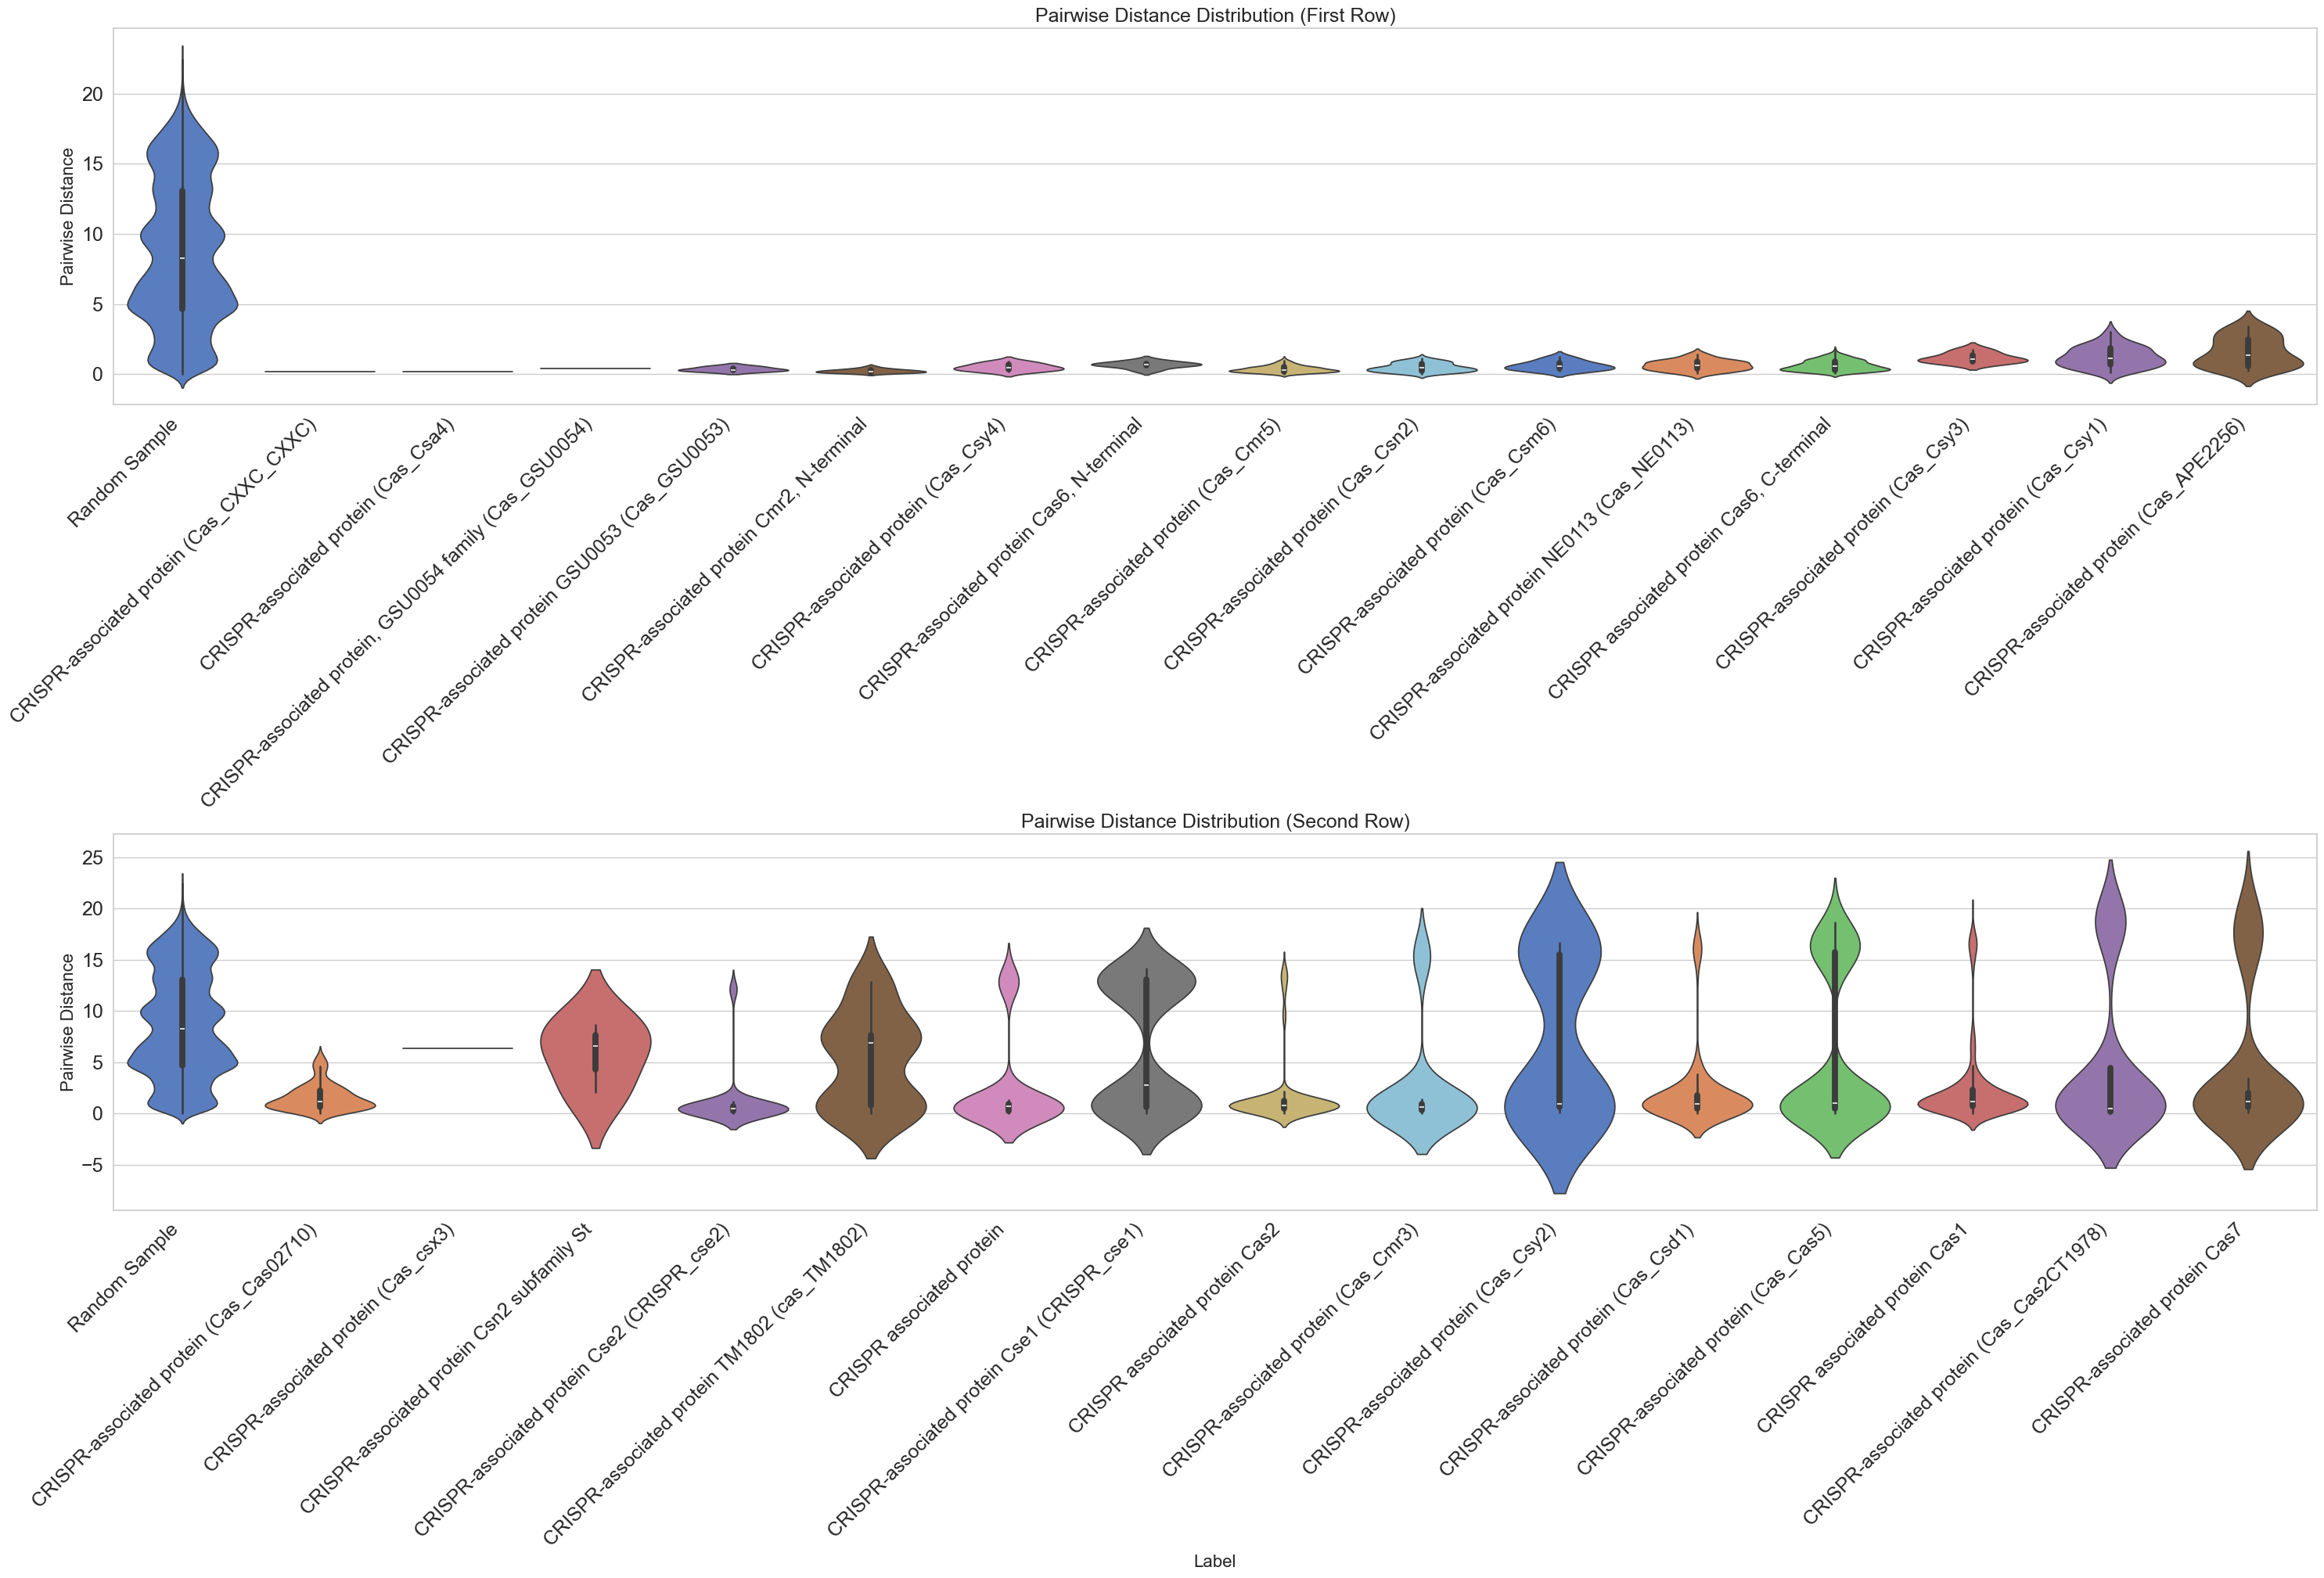

In [50]:
from scipy.spatial.distance import pdist, squareform
# Function to calculate pairwise distances
def calculate_pair_wise_distance(group):
    """
    Args:
    - group: DataFrame containing 'x', 'y' columns
    
    Returns:
    - distance_matrix: Squareform matrix of pairwise distances
    """
    embeddings = group[['x', 'y']].values
    pairwise_distances = pdist(embeddings, metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    return distance_matrix
import matplotlib.pyplot as plt

# 设置全局字体大小
plt.rcParams['font.size'] = 20  # 全局默认字体大小
plt.rcParams['axes.titlesize'] = 18  # 子图标题字体大小
plt.rcParams['axes.labelsize'] = 16  # x轴和y轴标签字体大小
plt.rcParams['xtick.labelsize'] = 18  # x轴刻度字体大小
plt.rcParams['ytick.labelsize'] = 18  # y轴刻度字体大小

# Randomly sample 500 points from the dataset
sampled_data = cas_associated_proteins_umap_embedding_non_duplicated_df.sample(n=500, random_state=42)

# Calculate pairwise distances for the random sample
distance_matrix = calculate_pair_wise_distance(sampled_data)

# Extract the upper triangular matrix (excluding the diagonal)
upper_triangle_values = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]

# Store the distance values in a DataFrame with a 'Random Sample' label
baseline_data = pd.DataFrame({'Distance': upper_triangle_values, 'Label': 'Random Sample'})

# Group by label and calculate pairwise distances for each group
grouped = sampled_data.groupby('Signature description')

# Collect all upper triangle distance values and add a label for each group
data = []
max_ranges = {}
plt.rcParams['font.size'] = 1
for label, group in grouped:
    distance_matrix = calculate_pair_wise_distance(group)
    # Extract the upper triangular matrix (excluding the diagonal)
    upper_triangle_values = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    if len(upper_triangle_values) > 0:  # Ensure the data is not empty
        data.append(pd.DataFrame({'Distance': upper_triangle_values, 'Label': label}))
        max_ranges[label] = upper_triangle_values.max()

# Combine all data into a single DataFrame
plot_data = pd.concat(data)

# Add the random sample data to the plot data
plot_data = pd.concat([baseline_data, plot_data])

# Sort labels by maximum distance value
sorted_labels = sorted(max_ranges.keys(), key=lambda x: max_ranges[x])

# Split sorted labels into two groups and add 'Random Sample' at the beginning of each
labels_group_1 = ['Random Sample'] + sorted_labels[:len(sorted_labels)//2]
labels_group_2 = ['Random Sample'] + sorted_labels[len(sorted_labels)//2:]

# Create the plot with two rows
fig, axes = plt.subplots(2, 1, figsize=(30, 20))  # Increased figure size for better spacing

# First row: Plot the first group of labels
sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_1)], 
               order=labels_group_1, inner="box", palette="muted", ax=axes[0])
axes[0].set_title("Pairwise Distance Distribution (First Row)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Pairwise Distance")
axes[0].set_xticks(np.arange(len(labels_group_1)))  # Ensure correct number of ticks
axes[0].set_xticklabels(labels_group_1, rotation=45, ha='right')  # Correct rotation and alignment

# Second row: Plot the second group of labels
sns.violinplot(x="Label", y="Distance", data=plot_data[plot_data['Label'].isin(labels_group_2)], 
               order=labels_group_2, inner="box", palette="muted", ax=axes[1])
axes[1].set_title("Pairwise Distance Distribution (Second Row)")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Pairwise Distance")
axes[1].set_xticks(np.arange(len(labels_group_2)))  # Ensure correct number of ticks
axes[1].set_xticklabels(labels_group_2, rotation=45, ha='right')  # Correct rotation and alignment

# Adjust layout
plt.tight_layout()
plt.show()


Found in single labels the number of labels that are larger than threshold is less than all labels, indicating some labels are in seqs with multiple labels.

calculate within pair wise distance and plot only in Cas1 & Cas2


# Task3 Semi-supervised Learning for unlabelled data!

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import scanpy as sc



# Prepare for data

In [6]:
import os
import glob
import pandas as pd
from Core.Utils.utils import  load_esm_embedding
#all protein accession
def create_protein_accession_df():
    """
    create a dataframe with all protein accession
    """
    _, esm_embedding_accession = ESMEmbedding(work_path).esm3_embedding
#create df
    esm_all_df = pd.DataFrame({
                            'Protein accession': esm_embedding_accession,
                            })
    esm_all_df = esm_all_df.sort_values(by='Protein accession').reset_index(drop=True)
    return esm_all_df

total_interpro_df = pd.read_csv(work_path.find_file_from_data_path('total_fasta_interpro.tsv'),sep='\t')
#load esm embedding and labels
esm_embedding, esm_embedding_accession = ESMEmbedding(work_path).esm3_embedding


#create df
esm_all_df = pd.DataFrame({
                        'Protein accession': esm_embedding_accession,
                        'esm_embedding':esm_embedding})
esm_all_df = esm_all_df.sort_values(by='Protein accession').reset_index(drop=True)



folder = work_path.environment_path  # The project folder of cluster of local
embedding_folder = 'Shenzhen_GLM_Project/Output'
data_folder = 'Shenzhen_GLM_Project/Data'

# Use glob to recursively find the file in the Output directory
umap_embedding_euc_df = pd.read_csv(glob.glob(os.path.join(folder, embedding_folder, '**', 'esm_3_umap_all_embedding_euclidean_top_10_pfam.csv'), recursive=True)[0])
umap_embedding_cos_df = pd.read_csv(glob.glob(os.path.join(folder, embedding_folder, '**', 'esm_3_umap_all_embedding_cosine_top_10_pfam.csv'), recursive=True)[0])
total_interpro_pfam_df = pd.read_csv(glob.glob(os.path.join(folder, data_folder, '**', 'total_interpro_pfam.csv'),recursive=True)[0])
protein_accession_df = create_protein_accession_df()


This is find path C:/Users/13330/OneDrive/工作/深圳---先进院/深圳--先进院--实习/Data\Data\Label\total_fasta_interpro.tsv
This is find path C:/Users/13330/OneDrive/工作/深圳---先进院/深圳--先进院--实习/Data\Data\Preparation_Data\total_esm3_normalized_embedding.pkl
This is find path C:/Users/13330/OneDrive/工作/深圳---先进院/深圳--先进院--实习/Data\Data\Preparation_Data\total_esm3_normalized_embedding.pkl


In [7]:
umap_embedding_euc_df['Protein accession'] = protein_accession_df['Protein accession']
#merge umap_embedding_euc_df and total_interpro_pfam_df, if multiple label exists, then keep multiple embeddings
total_interpro_pfam_df_filtered = total_interpro_pfam_df[['Protein accession', 'Signature description']]
umap_embedding_euc_all_pfam_df = pd.merge(umap_embedding_euc_df, total_interpro_pfam_df_filtered, on='Protein accession', how='left')

#separate non-labeled and labeled data
umap_embedding_euc_all_pfam_labeld_df = umap_embedding_euc_all_pfam_df[umap_embedding_euc_all_pfam_df['Signature description'].notna()]
umap_embedding_euc_all_pfam_non_labeld_df = umap_embedding_euc_all_pfam_df[umap_embedding_euc_all_pfam_df['Signature description'].isna()]


## Subtask3.1 Basic KNN for labeling data


# KNN Workflow

1. **Fit KNN Model**: 
   - Use `umap_embedding_all_pfam_df` (141297 entries) to fit the KNN model.

2. **Find Neighbors**:
   - For each label in `umap_embedding_all_pfam_df`, find nearest neighbors in `umap_embedding_all_pfam_df`.

3. **Assign Labels**:
   - Label the nearest neighbors in `umap_embedding_euc_all_pfam_non_labeld_df`.
   - a labeld data could have multiple labels, record each for non-labeled data

4. **Update Dataset**:
   - Merge labeled data into `umap_embedding_euc_all_df` to get the final labeled dataset.


plot of distributions of seqs with multiple annotations

In [10]:
from sklearn.neighbors import NearestNeighbors


class KNNPropagationKNC(NearestNeighbors):
    def __init__(self, n_neighbors=5, weights = 'distance', **kwargs):
        super().__init__(n_neighbors=n_neighbors,weights='distance',**kwargs)

    def nearest_indices(self, X):
        return self.kneighbors(X, return_distance=False)

    def nearest_distance(self, X):
        return self.kneighbors(X, return_distance=True)[0]



In [11]:
from sklearn.neighbors import NearestNeighbors


def filter_pfam_df(umap_embedding_pfam_df,threshold=50):
    """
    Only keep pfam annotations occure more than threshold
    """
    umap_embedding_pfam_df_copy = umap_embedding_pfam_df.copy()
    pfam_counts = umap_embedding_euc_all_pfam_df['Signature description'].value_counts()
    pfam_mapping = {val: (np.nan if count < threshold else val) for val, count in pfam_counts.items()}
    umap_embedding_pfam_df_copy['Signature description'] = umap_embedding_pfam_df_copy['Signature description'].map(pfam_mapping)
    return umap_embedding_pfam_df_copy

#define a KNN based search
class KNNPropgation(NearestNeighbors):
    def __init__(self, n_neighbors=5, **kwargs):
        super().__init__(n_neighbors=n_neighbors, **kwargs)

    def nearest_indices(self, X):
        return self.kneighbors(X, return_distance=False)
    
    def nearest_distance(self, X):
        return self.kneighbors(X, return_distance=True)[0]


Give new columns of if they have multiple labels

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 计算每个蛋白质的不同注释数量
annotation_counts = umap_embedding_euc_all_pfam_df.groupby('Protein accession')['Signature description'].nunique()

# 创建一个新的DataFrame，只包含每个蛋白质的一行
unique_proteins = umap_embedding_euc_all_pfam_df.drop_duplicates(subset='Protein accession')

# 添加 'annotation_count' 列
unique_proteins['annotation_count'] = unique_proteins['Protein accession'].map(annotation_counts)

# 获取统计信息
multiple_proteins = unique_proteins[unique_proteins['annotation_count'] > 1]
print(f"Total number of proteins with multiple different annotations: {len(multiple_proteins)}")
print(f"Total number of unique proteins: {len(unique_proteins)}")

# 创建图形和轴
fig, ax = plt.subplots(figsize=(14, 10))

# 创建颜色映射
cmap = plt.cm.get_cmap('Blues')
max_count = unique_proteins['annotation_count'].max()

# 绘制散点图
scatter = ax.scatter(unique_proteins['x'], unique_proteins['y'], 
                     c=unique_proteins['annotation_count'], 
                     cmap=cmap, 
                     norm=plt.Normalize(vmin=1, vmax=max_count),
                     alpha=0.6)

ax.set_title('UMAP Embedding of Proteins', fontsize=16)
ax.set_xlabel('UMAP1', fontsize=14)
ax.set_ylabel('UMAP2', fontsize=14)

# 添加颜色条
cbar = plt.colorbar(scatter)
cbar.set_label('Number of Different Annotations', fontsize=12)

plt.tight_layout()
plt.show()

# 显示具有多个不同注释的蛋白质的样本
print("\nSample of proteins with multiple different annotations:")
sample_proteins = multiple_proteins.nlargest(5, 'annotation_count')
for _, protein in sample_proteins.iterrows():
    print(f"\nProtein: {protein['Protein accession']}")
    print(f"Number of different annotations: {protein['annotation_count']}")
    annotations = umap_embedding_euc_all_pfam_df[umap_embedding_euc_all_pfam_df['Protein accession'] == protein['Protein accession']]['Signature description'].unique()
    print("Annotations:", ", ".join(annotations))

### Co-occurrence analysis

give each preotien accession a label of if multiple labels


In [8]:
annotation_counts = umap_embedding_euc_all_pfam_df.groupby('Protein accession')['Signature description'].nunique()

# 创建一个新的列 'if_multiple_labels'
umap_embedding_euc_all_pfam_df['if_multiple_labels'] = umap_embedding_euc_all_pfam_df['Protein accession'].map(annotation_counts > 1).astype(int)
#add a new column of protein index id
protein_ids, _ = pd.factorize(umap_embedding_euc_all_pfam_df['Protein accession'])
umap_embedding_euc_all_pfam_df['protein_id'] = protein_ids

#only keep per seq with unique different labels
umap_embedding_euc_all_pfam_no_duplicated_df = umap_embedding_euc_all_pfam_df.drop_duplicates(subset=['Protein accession','Signature description']).reset_index(drop=True)



先提取出X,Y of each seq, fit, 然后每个protein 有一个id, grouped by id, 然后查询对应的Signature description, 计算组合!

In [15]:
#prepare all embedding data
umap_embedding_euc_array = umap_embedding_euc_df.loc[:,['x','y']].to_numpy()
#set new KNN and fit all data
k = 14 # k needs to be added 1
KNN_serach = KNNPropgation(k)
#fit KNN
KNN_serach.fit(umap_embedding_euc_array)


KNNPropgation(n_neighbors=14)

In [16]:
#First find target seqs (with multiple pfam labels)
umap_embedding_multple_labels_id = umap_embedding_euc_all_pfam_no_duplicated_df[umap_embedding_euc_all_pfam_no_duplicated_df['if_multiple_labels'] == 1].protein_id.unique()
umap_embedding_euc_multi_pfam_array = umap_embedding_euc_array[umap_embedding_multple_labels_id,:]

#find nearest indices
KNN_nearest_ids = KNN_serach.nearest_indices(umap_embedding_euc_multi_pfam_array) #drop the point itself

umap_multi_self_id, umap_muliti_nearest_id = KNN_nearest_ids[:,0],KNN_nearest_ids[:,1:]
tem_id, tem_own_id = umap_muliti_nearest_id[0,], umap_multi_self_id[0,] #only for test single point
knn_nearest_id, knn_own_id = umap_muliti_nearest_id[0:,], umap_multi_self_id[0:,]


In [17]:

#first find nearst & self points' info
umap_nearest_info = umap_embedding_euc_all_pfam_no_duplicated_df.loc[umap_embedding_euc_all_pfam_no_duplicated_df['protein_id'].isin(tem_id)]
umap_self_info = umap_embedding_euc_all_pfam_no_duplicated_df.loc[umap_embedding_euc_all_pfam_no_duplicated_df['protein_id']== tem_own_id]
#then ignore points without label or single labels
umap_nearest_filtered_info = umap_nearest_info[umap_nearest_info['if_multiple_labels']==1]


- By each domain combination

find fisher example!!!!!!!

In [13]:
pro_id_1 = umap_multi_labels_df[umap_multi_labels_df['Signature description']=='HNH endonuclease'].protein_id.to_list()
pro_id_2 = umap_multi_labels_df[umap_multi_labels_df['Signature description']=='RRXRR protein'].protein_id.to_list()
pro_ids = pro_id_1 + pro_id_2

NameError: name 'umap_multi_labels_df' is not defined

In [552]:
test_df = pd.read_csv('../../Output/ESM/ESM_Embedding_Cosmograph/esm3_has_pfam_labels.csv')
test_df['type'] = test_df.apply(lambda x: 'RRXRR ' if x['id'] in pro_id_2 else 
                                'HNH endonuclease' if x['id'] in pro_id_1 else 'No', axis=1)
test_df.to_csv('../../Output/ESM/ESM_Embedding_Cosmograph/esm3_fisher_example_sig_2.csv')

In [488]:
#get self and nearst labels
umap_nearest_labels = list(umap_nearest_filtered_info.loc[:,'Signature description'].values)
umap_self_labels = list(umap_self_info.loc[:,'Signature description'].values)

umap_self_labels,umap_nearest_labels

(['Helix-turn-helix domain of resolvase', 'Resolvase, N terminal domain'],
 ['Integrase core domain',
  'Integrase zinc binding domain',
  'Recombinase',
  'Resolvase, N terminal domain'])

- For all labels count combinations

- By the whole protien

In [487]:
import pandas as pd
from itertools import combinations
umap_multi_labels_df = umap_embedding_euc_all_pfam_no_duplicated_df[umap_embedding_euc_all_pfam_no_duplicated_df['if_multiple_labels']==1]
df = umap_multi_labels_df.copy()
# Assuming your DataFrame is already loaded as df
# Group by 'protein_id' and aggregate 'Signature description' into lists
grouped = df.groupby('protein_id')['Signature description'].apply(list).reset_index()

# Initialize a list to store all the combinations
all_combinations = []

# Iterate over each row in the grouped DataFrame
for index, row in grouped.iterrows():
    descriptions = row['Signature description']
    
    # Only calculate combinations if there are two or more descriptions
    if len(descriptions) > 1:
        # Generate all possible combinations (pairs)
        comb = list(combinations(descriptions, 2))
        all_combinations.extend(comb)

# Convert the list of combinations to a set to get unique combinations
unique_combinations = set(all_combinations)

# Count the number of unique combinations
num_unique_combinations = len(unique_combinations)

# Display the result
print(f"Total unique combinations: {num_unique_combinations}")

unique_combinations


Total unique combinations: 4277


{('Large polyvalent protein-associated domain 3',
  'Transglycosylase SLT domain'),
 ('S-type Pyocin',
  'HNH/ENDO VII superfamily nuclease with conserved GHE residues'),
 ('5TMR of 5TMR-LYT', 'HD domain'),
 ('Transposase IS4', 'DDE_Tnp_1-like zinc-ribbon'),
 ('CRISPR associated protein Cas1', 'AAA ATPase domain'),
 ('Leucine Rich Repeat', 'Leucine rich repeat N-terminal domain'),
 ('Helix-turn-helix domain of transposase family ISL3',
  'zinc-finger binding domain of transposase IS66'),
 ('YDG domain', 'Divergent InlB B-repeat domain'),
 ('PemK-like, MazF-like toxin of type II toxin-antitoxin system',
  'NTF2-like N-terminal transpeptidase domain'),
 ('VWA / Hh  protein intein-like', 'Hint-domain'),
 ('Alpha helical recognition lobe domain', 'Nuclease domain'),
 ('Molybdopterin oxidoreductase Fe4S4 domain', 'Molybdopterin oxidoreductase'),
 ('DEAD/DEAH box helicase', 'RecQ zinc-binding'),
 ('Kelch motif', 'Galactose oxidase, central domain'),
 ('CHC2 zinc finger', 'DNA primase catalyt

In [475]:
import pandas as pd
from itertools import combinations
from collections import Counter

# Assuming your DataFrame is already loaded as df
# Group by 'protein_id' and aggregate 'Signature description' into lists
grouped = df.groupby('protein_id')['Signature description'].apply(list).reset_index()

# Initialize a list to store all the combinations
all_combinations = []

# Iterate over each row in the grouped DataFrame
for index, row in grouped.iterrows():
    descriptions = row['Signature description']
    
    # Only calculate combinations if there are two or more descriptions
    if len(descriptions) > 1:
        # Generate all possible combinations (pairs)
        comb = list(combinations(descriptions, 2))
        all_combinations.extend(comb)

# Count the occurrences of each combination
combination_counts = Counter(all_combinations)

# Convert to a DataFrame for better viewing
combination_df = pd.DataFrame(combination_counts.items(), columns=['Combination', 'Count'])

# Display the result

# Display the first few rows for verification
combination_df.sort_values(by='Count')


Combination  Count
2138  (Helix-turn-helix domain, DNA N-6-adenine-meth...      1
2800      (FG-GAP-like repeat, S-layer homology domain)      1
2801        (Calx-beta domain, S-layer homology domain)      1
2802  (MobA-like NTP transferase domain, Bacterial t...      1
2803  (Bacterial Ig domain, Prealbumin-like fold dom...      1
...                                                 ...    ...
48    (DEAD/DEAH box helicase, Helicase conserved C-...     81
67    (RuvC endonuclease subdomain 3, HNH endonuclease)    115
216   (HNH endonuclease, RuvC endonuclease subdomain 3)    119
79    (Initiator Rep protein, WH2, Initiator Replica...    122
86    (Initiator Replication protein, WH1, Initiator...    125

[4277 rows x 2 columns]

In [56]:
import os
from itertools import product

# Function to compute label combinations
def combination_count(nearest_id, own_id, strategy='product'):
    """
    Give nearest ids and own id, count combinations.
    strategy: calculate combinations of all labels or just product with neighbor labels
    """
    assert strategy in ['combination', 'product'], 'Strategy should be "all" or "self"!'
    nearest_info = umap_embedding_euc_all_pfam_no_duplicated_df.loc[umap_embedding_euc_all_pfam_no_duplicated_df['protein_id'].isin(nearest_id)]
    self_info = umap_embedding_euc_all_pfam_no_duplicated_df.loc[umap_embedding_euc_all_pfam_no_duplicated_df['protein_id'] == own_id]
    nearest_filtered_info = nearest_info[nearest_info['if_multiple_labels'] == 1] #only consider seqs with multiple labels
    nearest_labels = list(nearest_filtered_info['Signature description'].values)
    self_labels = list(self_info['Signature description'].values)
    combination_labels = product(self_labels,nearest_labels)
    return combination_labels


[('Helix-turn-helix domain of resolvase', 'Integrase core domain'),
 ('Helix-turn-helix domain of resolvase', 'Integrase zinc binding domain'),
 ('Helix-turn-helix domain of resolvase', 'Recombinase'),
 ('Helix-turn-helix domain of resolvase', 'Resolvase, N terminal domain'),
 ('Resolvase, N terminal domain', 'Integrase core domain'),
 ('Resolvase, N terminal domain', 'Integrase zinc binding domain'),
 ('Resolvase, N terminal domain', 'Recombinase'),
 ('Resolvase, N terminal domain', 'Resolvase, N terminal domain')]

In [71]:

# Function to write combinations to a text file in append mode
def write_combinations(combination_labels, filename='product_k_13_raw.txt', save_path=None):
    # Create the full path if save_path is provided
    if save_path:
        # Ensure the save_path exists, create it if necessary
        os.makedirs(save_path, exist_ok=True)
        path = os.path.join(save_path, filename)
    else:
        path = filename
    
    # Check if the file exists and is empty (to avoid adding headers multiple times)
    write_header = not os.path.exists(path) or os.path.getsize(path) == 0

    # Open the text file in append mode ('a')
    with open(path, mode='a') as file:  # 'a' means append mode
        # Write the header only if the file is new or empty
        if write_header:
            file.write('Label1\tLabel2\n')  # Write header only once
        
        # Iterate through each combination and write to the file
        for comb in combination_labels:
            # Join the combination as a string and write it to the file
            file.write('\t'.join(comb) + '\n')

# Function to handle the combination process and writing for each sample
def process_sample(nearest_id, own_id, filename='product_k_13_co_occur_raw.txt', save_path=None):
    # Compute combinations
    combinations_labels = combination_count(nearest_id, own_id)
    # Write combinations to file (in append mode)
    write_combinations(combinations_labels, filename, save_path)

# Apply process_sample to each sample using map
def process_all_samples(nearest_ids_array, own_ids, filename='product_k_13_co_occur_raw.txt', save_path=None):
    # Use map to apply process_sample to all samples
    list(map(lambda nearest_ids, own_id: process_sample(nearest_ids, own_id, filename, save_path),
             nearest_ids_array, own_ids))

# Example usage
# Corrected usage: ensure filename is the third argument and the path is the fourth


process_all_samples(knn_nearest_id, knn_own_id, 'product_k_13_co_occur_raw.txt', '../../Output/ESM/Embedding_analysis/')


Now you already got raw knn_13_co_occurrence data! congratulations!
Now need to further analysis!

In [163]:
#read raw data
umap_co_occur_raw_df = pd.read_csv('../../Output/ESM/Embedding_analysis/product_k_13_co_occur_raw.txt',sep='\t')

#umap_co_occur_raw.columns = ['Label_1','Label_2']
# Create a new DataFrame by grouping Label_1 and Label_2 combinations and counting occurrences
combination_counts = umap_co_occur_raw_df.groupby(['Label1', 'Label2']).size().reset_index(name='Count')

# Sort the resulting DataFrame by the 'Count' column in descending order
combination_counts = combination_counts.sort_values(by='Count', ascending=False)

# filter out self combinations


# Fisher's 精确检验列联表

具体例子：
假设我们在研究两个蛋白质域的共现：
- 特征1: HNH endonuclease
- 特征2: RuvC endonuclease subdomain 3


+-----------------+---------------+----------------+--------+
|                 | RuvC 存在     | RuvC 不存在    | 总计   |
+-----------------+---------------+----------------+--------+
| HNH 存在        |    7900       |     1234       |  9134  |
+-----------------+---------------+----------------+--------+
| HNH 不存在      |    3259       |    87607       | 90866  |
+-----------------+---------------+----------------+--------+
| 总计            |   11159       |    88841       | 100000 |
+-----------------+---------------+----------------+--------+

In [491]:
import collections
import pandas as pd

def count_combinations_to_df(file_path):
    # Initialize a Counter to store combination counts
    combination_counter = collections.Counter()

    # Open the file and process each line
    with open(file_path, 'r') as file:
        # Skip the header
        next(file)

        for line in file:
            # Split the line into two labels
            label1, label2 = line.strip().split('\t')

            # Sort the labels so that A-B and B-A are treated the same
            sorted_comb = tuple(sorted([label1, label2]))

            # Increment the counter for this combination
            combination_counter[sorted_comb] += 1

    # Convert the Counter data to a list of dictionaries for the DataFrame
    data = [{'Label1': comb[0], 'Label2': comb[1], 'Count': count} for comb, count in combination_counter.items()]
    
    # Create a DataFrame
    df = pd.DataFrame(data)

    return df

def pfam_occurrence_counts(pfam_1,pfam_2):
    pfam_1_counts = len(umap_embedding_euc_all_pfam_no_duplicated_df[
        (umap_embedding_euc_all_pfam_no_duplicated_df['Signature description'] == pfam_1) & 
        (umap_embedding_euc_all_pfam_no_duplicated_df['if_multiple_labels'] == 1)
    ])
    
    pfam_2_counts = len(umap_embedding_euc_all_pfam_no_duplicated_df[
        (umap_embedding_euc_all_pfam_no_duplicated_df['Signature description'] == pfam_2) & 
        (umap_embedding_euc_all_pfam_no_duplicated_df['if_multiple_labels'] == 1)])

    return (pfam_1_counts,pfam_2_counts)


# Example usage
file_path = '../../Output/ESM/Embedding_analysis/product_k_13_co_occur_raw.txt'  # Replace with your actual file path
umap_co_occur_symmetric_df = count_combinations_to_df(file_path) # make symmtric A-->B = B-->
umap_co_occur_symmetric_df
df = umap_co_occur_symmetric_df.copy()

In [492]:
from typing import Counter


df_no_same = df[df['Label1'] !=df['Label2']]
df_same = df[df['Label1']==df['Label2']]
label1_counts = dict(df_no_same.groupby('Label1')['Count'].sum())
label2_counts = dict(df_no_same.groupby('Label2')['Count'].sum())
label3_counts = dict(df_same.groupby('Label1')['Count'].sum())


In [493]:
# Combine the counts from label1_counts, label2_counts, and label3_counts
total_counts = Counter(label1_counts) + Counter(label2_counts) + Counter(label3_counts)
# Convert the result back to a dictionary if needed
total_counts_dict = dict(total_counts)

Run fisher

In [494]:
df['Total_Label_1'] = df['Label1'].map(total_counts_dict)
df['Total_Label_2'] = df['Label2'].map(total_counts_dict)

df

Label1  \
0               Helix-turn-helix domain of resolvase   
1               Helix-turn-helix domain of resolvase   
2               Helix-turn-helix domain of resolvase   
3               Helix-turn-helix domain of resolvase   
4                              Integrase core domain   
...                                              ...   
20672        Putative transposase DNA-binding domain   
20673  FKBP-type peptidyl-prolyl cis-trans isomerase   
20674                         Choline-binding repeat   
20675               Domain of unknown function DUF11   
20676                         Choline-binding repeat   

                                              Label2  Count  Total_Label_1  \
0                              Integrase core domain      4            135   
1                      Integrase zinc binding domain      2            135   
2                                        Recombinase     21            135   
3                       Resolvase, N terminal domain     23            135   
4                       Resolvase, N terminal domain      4            588   
...                                              ...    ...            ...   
20672                  Transposase-associated domain      1           1528   
20673              Putative cell wall binding repeat      1            124   
20674  FKBP-type peptidyl-prolyl cis-trans isomerase      1           1581   
20675              Putative cell wall binding repeat      1            328   
20676               Domain of unknown function DUF11      1           1581   

       Total_Label_2  
0                588  
1                325  
2                708  
3                700  
4                700  
...              ...  
20672             41  
20673           1390  
20674            124  
20675           1390  
20676            328  

[20677 rows x 5 columns]

In [495]:
import pandas as pd
import numpy as np

# 复制数据
# 计算 Label1 和 Label2 的总出现次数
label1_counts = df.groupby('Label1')['Count'].sum()
label2_counts = df.groupby('Label2')['Count'].sum()

# 添加 Label1 和 Label2 的单独出现次数
result_df = df.copy()

# 初始化一个新的列来存储 p 值
df['p_value'] = 0.0

# 获取所有独特的 Label1 和 Label2 的组合
all_labels_1 = df['Label1'].unique()
all_labels_2 = df['Label2'].unique()

# 遍历每一行计算 Fisher's exact test
for index, row in df.iterrows():
    label1 = row['Label1']
    label2 = row['Label2']
    a = row['Count']
    
    # b 是 Label1 是 label1 且 Label2 不是 label2 的总和
    b = row['Total_Label_1'] - row['Count']

    
    # c 是 Label1 不是 label1 且 Label2 是 label2 的总和
    c = row['Total_Label_2'] - row['Count']

    # d 是 Label1 不是 label1 且 Label2 也不是 label2 的总和

    d = df['Count'].sum() - row['Total_Label_1'] - row['Total_Label_2'] + row['Count']
    total_sum = df['Count'].sum()  # 获取总的 Count 总和
    
    # 构建 2x2 列联表
    contingency_table = [[a, b], [c, d]]
    
    # 计算 Fisher's exact test 的 p 值
    _, p_value = fisher_exact(contingency_table,alternative='greater')
    
    # 保存 p 值
    df.at[index, 'p_value'] = p_value

# 显示包含 Fisher's exact test 结果的最终 DataFrame

In [497]:
import statsmodels.stats.multitest as smm
p_values_raw = df.p_value.values
rejected, adjusted_p_values = smm.multipletests(p_values_raw, alpha=0.05, method='fdr_bh')[:2]
df['p_value_fdr'] = adjusted_p_values

In [500]:

threshold = 20


df_filtered = df[df['Count'] >= threshold]

df_filtered.sort_values(by='p_value_fdr',ascending=False).head(50)

Label1  \
3550                      CRISPR associated protein Cas1   
3279   Histidine kinase-, DNA gyrase B-, and HSP90-li...   
2544                                           HD domain   
207                       Cas9 alpha-helical lobe domain   
415                                            HD domain   
3967                   Diguanylate cyclase, GGDEF domain   
11815                                       Cache domain   
3552                      CRISPR associated protein Cas1   
4329                              DEAD/DEAH box helicase   
1436                                          AAA domain   
2736                                          AAA domain   
267                                     HNH endonuclease   
3288                             Helix-turn-helix domain   
3280                             Helix-turn-helix domain   
263                                     HNH endonuclease   
5500                                            PAS fold   
8611   Methyl-accepting chemotaxis protein (MCP) sign...   
3811   Histidine kinase-, DNA gyrase B-, and HSP90-li...   
3551                      CRISPR associated protein Cas1   
3806                                         HAMP domain   
1875   Bridge helix of CRISPR-associated endonuclease...   
488                              Helix-turn-helix domain   
211                       Cas9 alpha-helical lobe domain   
3745                              DEAD/DEAH box helicase   
1224                                    Helix-turn-helix   
3113                   Diguanylate cyclase, GGDEF domain   
11806                                       Cache domain   
5903                                        Cache domain   
7611                   Diguanylate cyclase, GGDEF domain   
11793                                         GAF domain   
5503                                    Histidine kinase   
443              Putative transposase DNA-binding domain   
5053                                     Cas3, HD domain   
1168                              Cas3 C-terminal domain   
8505                                    Histidine kinase   
8614                                        Cache domain   
3742                                          HTH domain   
11790         Bacterial regulatory proteins, luxR family   
6296                                          EAL domain   
10749         Bacterial regulatory proteins, luxR family   
1220                                    Helix-turn-helix   
7609                   Diguanylate cyclase, GGDEF domain   
492                                     Helix-turn-helix   
1448                                            PAS fold   
3966                                          GAF domain   
160             Type III restriction enzyme, res subunit   
396           Bacterial regulatory proteins, luxR family   
566                               CRISPR-Cas9 WED domain   
403           Bacterial regulatory proteins, luxR family   
476                       Cas9 alpha-helical lobe domain   

                                                  Label2  Count  \
3550                                    HNH endonuclease     39   
3279             Putative transposase DNA-binding domain     22   
2544                                            PAS fold     23   
207    PAM-interacting domain of CRISPR-associated en...     56   
415                   Response regulator receiver domain     23   
3967                                         HAMP domain     25   
11815  Histidine kinase-, DNA gyrase B-, and HSP90-li...     20   
3552                       RuvC endonuclease subdomain 3     31   
4329   Reverse transcriptase (RNA-dependent DNA polym...     21   
1436                  Response regulator receiver domain     20   
2736   Histidine kinase-, DNA gyrase B-, and HSP90-li...     23   
267                                 RuvC nuclease domain     56   
3288                                            PAS fold     27   
3280   Histidine kinase-, DNA gyrase B-, and HSP90-

In [556]:
umap_co_occur_raw_df[(umap_co_occur_raw_df['Label1']=='RRXRR protein') &(umap_co_occur_raw_df['Label1']=='HNH endonuclease') ]

Empty DataFrame
Columns: [Label1, Label2]
Index: []

In [550]:
df[df['Label2']=='RRXRR protein']

Label1         Label2  \
462                               Cas9 C-terminal domain  RRXRR protein   
474    CRISPR-associated endonuclease Cas9 beta-hairp...  RRXRR protein   
476                       Cas9 alpha-helical lobe domain  RRXRR protein   
477                                     HNH endonuclease  RRXRR protein   
1079   Bridge helix of CRISPR-associated endonuclease...  RRXRR protein   
1549   PAM-interacting domain of CRISPR-associated en...  RRXRR protein   
1550     REC lobe of CRISPR-associated endonuclease Cas9  RRXRR protein   
6200                                       RRXRR protein  RRXRR protein   
17621                              CRISPR-Cas9 PI domain  RRXRR protein   
17622                             CRISPR-Cas9 WED domain  RRXRR protein   

       Count  Total_Label_1  Total_Label_2       p_value   p_value_fdr  
462       33            937            516  2.328391e-24  1.022168e-22  
474       33            937            516  2.328391e-24  1.022168e-22  
476       25           4180            516  1.376701e-03  2.781789e-03  
477      181          21075            516  7.233613e-40  5.380195e-38  
1079      24           1651            516  6.340867e-10  8.133382e-09  
1549       8           3496            516  8.396453e-01  8.648242e-01  
1550      37           4506            516  9.403967e-08  7.821634e-07  
6200      24            516            516  7.960446e-21  2.897855e-19  
17621      4           1029            516  3.864470e-01  4.152021e-01  
17622      4           1115            516  4.449363e-01  4.740042e-01

In [221]:
from scipy.stats import fisher_exact
import numpy as np

# 原始数据
original_table = np.array([[4, 131],
                           [584, ]])

# 新数据
new_table = np.array([[790, 8344],
                      [325, 90541]])

def analyze_table(table, name):
    odds_ratio, p_value = fisher_exact(table,'greater')
    print(f"{name} 结果:")
    print(f"Odds Ratio: {odds_ratio:.4f}")
    print(f"P-value: {p_value:.2e}")
    print(f"总样本数: {np.sum(table)}")
    print(f"共现比例: {table[0,0] / np.sum(table):.4%}")
    print()

analyze_table(original_table, "原始数据")
analyze_table(new_table, "新数据")

原始数据 结果:
Odds Ratio: 1.3889
P-value: 1.71e-01
总样本数: 790
共现比例: 2.5316%

新数据 结果:
Odds Ratio: 26.3764
P-value: 0.00e+00
总样本数: 100000
共现比例: 0.7900%



In [ ]:

#normalize co-occurrence
def calculate_normalization_factor(pfam_count_1, pfam_count_2):
    return np.sqrt(pfam_count_1 * pfam_count_2)

def co_occur_normalized_df(co_occurrence_df, reference_df):
    # 创建一个新的 DataFrame 来存储归一化后的结果
    normalized_df = co_occurrence_df.copy()
    
    # 只考虑 if_multiple_labels 为 1 的行
    multiple_labels_df = reference_df[reference_df['if_multiple_labels'] == 1]
    
    # 预先计算所有 pfam 的出现次数（只在多标签蛋白质中）
    pfam_counts = multiple_labels_df['Signature description'].value_counts()
    
    def process_row(row):
        pfam_1 = row['Label1']
        pfam_2 = row['Label2']
        
        # 查表获取每个 pfam 的出现次数
        pfam_1_count = pfam_counts.get(pfam_1, 0)
        pfam_2_count = pfam_counts.get(pfam_2, 0)
        
        # 计算归一化因子
        factor = calculate_normalization_factor(pfam_1_count, pfam_2_count)
        
        # 计算归一化后的计数
        normalized_count = row['Count'] / factor if factor != 0 else 0
        
        return pd.Series({
            'Label1_Count': pfam_1_count,
            'Label2_Count': pfam_2_count,
            'Normalization_Factor': factor,
            'Count_normalized': normalized_count
        })
    
    # 应用处理函数到每一行
    result = normalized_df.apply(process_row, axis=1)
    
    # 将结果合并到原始 DataFrame
    normalized_df = pd.concat([normalized_df, result], axis=1)
    
    return normalized_df

# 使用函数
normalized_co_occur_df = co_occur_normalized_df(co_occur_df, umap_embedding_euc_all_pfam_no_duplicated_df)


In [48]:
#set a threshold to filter out co-occurrence too low
threshold = 30
filtered_df = normalized_co_occur_df[(normalized_co_occur_df['Label1'] != normalized_co_occur_df['Label2']) & 
                                     (normalized_co_occur_df['Count'] >= threshold)]
#drop self connection
filtered_df.to_csv('../../Output/ESM/Embedding_analysis/co_occurrence_Ochiai_normalized_0.txt',sep='\t')

In [341]:
import pandas as pd

# 计算每个蛋白质的不同注释数量
annotation_counts = umap_embedding_euc_all_pfam_df.groupby('Protein accession')['Signature description'].nunique()

# 创建一个新的列 'if_multiple_labels'
umap_embedding_euc_all_pfam_df['if_multiple_labels'] = umap_embedding_euc_all_pfam_df['Protein accession'].map(annotation_counts > 1).astype(int)

# 显示结果的前几行
print(umap_embedding_euc_all_pfam_df[['Protein accession', 'Signature description', 'if_multiple_labels']].head(10))

# 统计信息
total_proteins = umap_embedding_euc_all_pfam_df['Protein accession'].nunique()
multiple_label_proteins = umap_embedding_euc_all_pfam_df[umap_embedding_euc_all_pfam_df['if_multiple_labels'] == 1]['Protein accession'].nunique()

print(f"\nTotal number of unique proteins: {total_proteins}")
print(f"Number of proteins with multiple labels: {multiple_label_proteins}")
print(f"Percentage of proteins with multiple labels: {multiple_label_proteins/total_proteins:.2%}")

                            Protein accession  \
0             2800531478 hypothetical protein   
1    EMBL_ERZ1022727&&contig_36&&3605_4121_-1   
2    EMBL_ERZ1022742&&contig_2860&&482_1856_1   
3      EMBL_ERZ1022753&&contig_3010&&33_588_1   
4  EMBL_ERZ1022756&&contig_46&&29777_30431_-1   
5   EMBL_ERZ1022756&&contig_717&&7596_7962_-1   
6    EMBL_ERZ1022758&&contig_121&&1720_2167_1   
7    EMBL_ERZ1022763&&contig_333&&745_1993_-1   
8    EMBL_ERZ1022779&&contig_554&&128_3227_-1   
9    EMBL_ERZ1022808&&contig_810&&163_1435_-1   

                       Signature description  if_multiple_labels  
0                                        NaN                   0  
1                                        NaN                   0  
2                                        NaN                   0  
3                                        NaN                   0  
4                                        NaN                   0  
5                                        NaN              

## Subtask 3.2 PAGA of embedding  (Only Cas)

In [199]:
import numpy as np
target_labels = ['CRISPR associated protein Cas1','CRISPR associated protein Cas2']
#get corresponding pfam
interpro_cas_all = total_interpro_df[total_interpro_df['Signature description'].isin(target_labels)]
interpro_cas_all = interpro_cas_all[interpro_cas_all['Analysis'] == 'Pfam']
#drop duplicated (some seqs have multiple cas1 or cas2 
interpro_cas = interpro_cas_all.drop_duplicates(subset=['Protein accession','Signature description'])
interpro_cas = interpro_cas.loc[:, ['Protein accession', 'Signature description']].reset_index(drop=True)
interpro_cas = interpro_cas.drop_duplicates('Protein accession')

In [84]:
#merge with all esm
interpro_cas = pd.merge(interpro_cas,esm_all_df,how='left',on='Protein accession')
interpro_cas_embedding, interpro_cas_labels = np.vstack(interpro_cas.esm_embedding.values),np.vstack(interpro_cas.loc[:,'Signature description'].values)

- PAGA by louvain

In [134]:
#get adata for X
esm_cas_pfam_embedding_adata = sc.AnnData(interpro_cas_embedding)
esm_cas_pfam_embedding_adata.obs['Signature description'] = interpro_cas['Signature description'].values
esm_cas_pfam_embedding_adata.obs['Protein accession'] = interpro_cas['Protein accession'].values

In [135]:
#add obs

#esm_all_pfam_embedding_adata.obs['Signature description'] = esm_all_pfam_embedding_df_filtered.values
esm_cas_pfam_embedding_adata.X = esm_cas_pfam_embedding_adata.X.astype("float64")
#run neighbors
sc.pp.neighbors(esm_cas_pfam_embedding_adata, n_neighbors=15, n_pcs=20,use_rep='X')


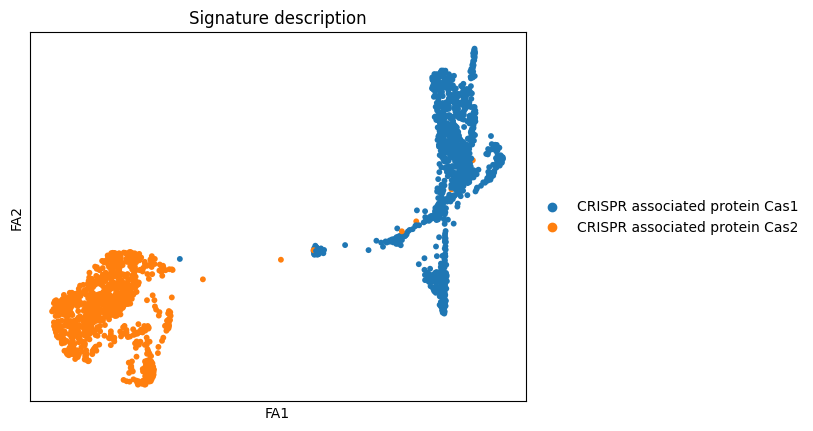

In [91]:
sc.tl.draw_graph(esm_cas_pfam_embedding_adata)
sc.pl.draw_graph(esm_cas_pfam_embedding_adata, color='Signature description')

In [136]:
#run louvain
sc.tl.louvain(esm_cas_pfam_embedding_adata, 1)
#run paga
sc.tl.paga(esm_cas_pfam_embedding_adata, groups='louvain')

In [141]:
import pandas as pd

# Assuming your AnnData object is named adata
# Convert AnnData obs to DataFrame

# Find the most common Signature description for each louvain group
def get_most_common_label(group):
    return group['Signature description'].value_counts().index[0]

most_common_labels = esm_cas_pfam_embedding_adata.obs.groupby('louvain').apply(get_most_common_label)

# Create new louvain_new_group column
esm_cas_pfam_embedding_adata.obs['louvain_new_group'] = esm_cas_pfam_embedding_adata.obs['louvain'].map(lambda x: f"{x}/{most_common_labels[x]}")


C:\Users\13330\AppData\Local\Temp\ipykernel_27660\2649165808.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  most_common_labels = esm_cas_pfam_embedding_adata.obs.groupby('louvain').apply(get_most_common_label)
C:\Users\13330\AppData\Local\Temp\ipykernel_27660\2649165808.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_common_labels = esm_cas_pfam_embedding_adata.obs.groupby('louvain').apply(get_most_common_label)


C:\Users\13330\AppData\Local\Temp\ipykernel_27660\218607681.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

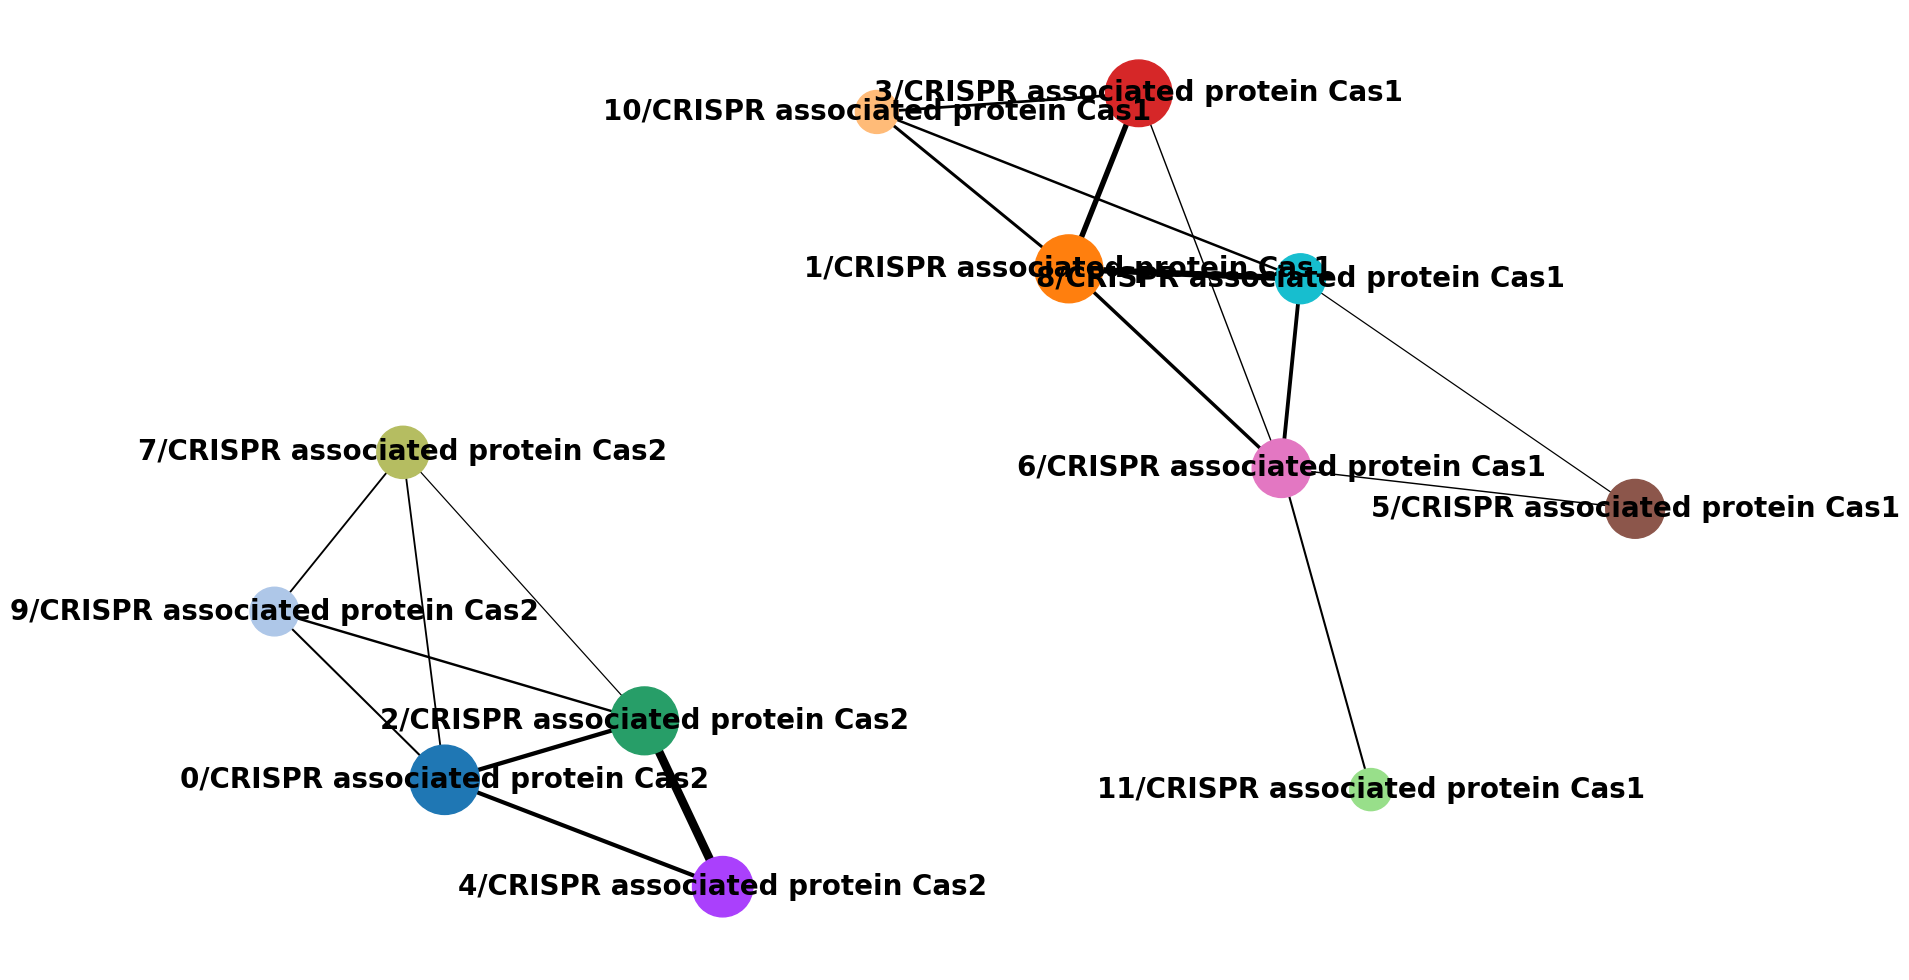

In [143]:
import matplotlib.pyplot as plt
sc.tl.paga(esm_cas_pfam_embedding_adata, groups='louvain_new_group')
# 增加默认字体大小
plt.rcParams.update({'font.size': 14})  # 你可以根据需要调整这个值

plt.figure(figsize=(12, 8))
sc.pl.paga(esm_cas_pfam_embedding_adata, threshold=0.1, color='louvain_new_group', show=False,
           node_size_scale=12,  # 增加节点大小
           edge_width_scale=1,   # 增加边的宽度
           fontsize=20,          # 设置标签字体大小
           fontweight='bold',
           frameon=False,
           random_state=42,)        # 移除边框以减少视觉干扰
plt.gcf().set_size_inches(20,12)

plt.tight_layout()
plt.show()


by louvain groups

In [129]:
import pandas as pd

# 获取唯一的 Louvain 组
unique_louvain_groups = esm_cas_pfam_embedding_adata.obs['louvain'].unique()

group_labels = []
for group in unique_louvain_groups:
    group_data = esm_cas_pfam_embedding_adata.obs[esm_cas_pfam_embedding_adata.obs['louvain'] == group]
    label_counts = group_data['Signature description'].value_counts()
    
    # 移除 'No' 标签并计算非 'No' 标签的总数
    if 'No' in label_counts.index:
        no_count = label_counts['No']
        label_counts = label_counts.drop('No')
        non_no_total = len(group_data) - no_count
    else:
        non_no_total = len(group_data)
    
    if not label_counts.empty:
        top_label = label_counts.index[0]
        top_count = label_counts.iloc[0]
        proportion = top_count / non_no_total if non_no_total > 0 else 0
    else:
        top_label = 'N/A'
        top_count = 0
        proportion = 0
    
    group_labels.append({
        'Louvain Group': group,
        'Top Label': top_label,
        'Top Label Count': top_count,
        'Proportion': proportion,
        'Total Size': len(group_data),
        'Non-No Size': non_no_total
    })

# 创建 DataFrame
group_labels_df = pd.DataFrame(group_labels)

# 计算 Louvain 组的大小
group_sizes = esm_cas_pfam_embedding_adata.obs['louvain'].value_counts()

# 显示结果
print(f"Number of unique Louvain groups: {len(unique_louvain_groups)}")
print("\nFirst few rows of group_labels_df:")
print(group_labels_df.head())
print("\nTotal number of rows in group_labels_df:", len(group_labels_df))

Number of unique Louvain groups: 12

First few rows of group_labels_df:
  Louvain Group                       Top Label  Top Label Count  Proportion  \
0             3  CRISPR associated protein Cas1              224    0.995556   
1             6  CRISPR associated protein Cas1              132    0.985075   
2             2  CRISPR associated protein Cas2              242    1.000000   
3             1  CRISPR associated protein Cas1              241    0.991770   
4             5  CRISPR associated protein Cas1              137    1.000000   

   Total Size  Non-No Size  
0         225          225  
1         134          134  
2         242          242  
3         243          243  
4         137          137  

Total number of rows in group_labels_df: 12


### How to assign each group?
- Assign top n pfam labels

In [ ]:
import matplotlib.pyplot as plt

# 增加默认字体大小
plt.rcParams.update({'font.size': 14})  # 你可以根据需要调整这个值

plt.figure(figsize=(12, 8))
sc.pl.paga(esm_all_pfam_embedding_adata, threshold=0.4, color='louvain_new_group', show=False,
           node_size_scale=12,  # 增加节点大小
           edge_width_scale=1,   # 增加边的宽度
           fontsize=25,          # 设置标签字体大小
           fontweight='bold',
           frameon=False,
           random_state=42,)        # 移除边框以减少视觉干扰
plt.gcf().set_size_inches(50,40)

plt.tight_layout()
plt.show()

## Subtask 3.3 KNN label propagation

In [18]:
from collections import Counter
k = 20 # k needs to be added 1
KNN_serach = KNNPropgation(k)
KNN_serach.fit(umap_embedding_euc_array)

KNNPropgation(n_neighbors=20)

In [19]:
#First find target seqs (occurrence larger than threshold)
threshold = 0
pfam_no_duplicated_counts = umap_embedding_euc_all_pfam_no_duplicated_df.loc[:,'Signature description'].value_counts()
pfam_no_duplicated = pfam_no_duplicated_counts[pfam_no_duplicated_counts >= threshold].index
umap_embedding_euc_filter_pfam_df = umap_embedding_euc_all_pfam_no_duplicated_df[umap_embedding_euc_all_pfam_no_duplicated_df.loc[:,'Signature description'].isin(pfam_no_duplicated)].reset_index(drop=True)
umap_embedding_euc_no_label_pfam_df = umap_embedding_euc_all_pfam_no_duplicated_df[umap_embedding_euc_all_pfam_no_duplicated_df.loc[:,'Signature description'].isna()]
#encode each pfam label (rank by occurrences)
pfam_labels_encoding = {label: idx for idx, label in enumerate(pfam_no_duplicated)}

In [20]:
#get labeld ids
umap_embedding_label_id = umap_embedding_euc_filter_pfam_df.protein_id.unique()
umap_embedding_label_array = umap_embedding_euc_array[umap_embedding_label_id,]
#all nearest (include self data) ids
KNN_nearest_ids = KNN_serach.nearest_indices(umap_embedding_label_array)
umap_label_self_id, umap_label_nearest_id = KNN_nearest_ids[:,0], KNN_nearest_ids[:,1:]
umap_label_nearest_dist = KNN_serach.nearest_distance(umap_embedding_label_array)[:,1:]

Plot seqs with labels & without labels

- Frist for every point (embedding), find their labels, iter the labels
- For each label of each point, record the label in iteration, record like: {'pro_id':{'unknown_id':[],'label_n':{'support':x,'mean_distance':[],'median_distance':[]}}}
- Then for each unknown id, calculate by methods(support nums, mean distance...) to decide assignment

In [20]:
tem_self_id,tem_nearest_id = umap_label_self_id[1,], umap_label_nearest_id[1,:]
tem_nearest_dist = umap_label_nearest_dist[1,:]
label_pfam_meta_dict = {}

def add_labels(knn_self_id, knn_nearest_id, knn_nearest_dist, umap_label_df, pfam_labels_encoding):
    """
    Add labels, initialize metadata for a single embedding point, and calculate support for each label.
    """
    df = umap_label_df.copy()

    # Initialize lists to store no-label info
    nolabel_ids = []
    label_id_distances = []
    label_ids = []
    
    # Dictionary to store label counts from neighbors
    label_counts = Counter()
    
    # Dictionary to store pro_id and encoded labels for each neighbor
    neighbor_labels_dict = {}

    # Loop over nearest neighbors to check if they have labels
    for idx, neighbor_id in enumerate(knn_nearest_id):
        # Check if the neighbor has a label
        neighbor_row = df[df['protein_id'] == neighbor_id]
        
        if not neighbor_row.empty:  # If the neighbor has a label
            labels = neighbor_row['Signature description'].values  # Extract all labels for this neighbor
            
            # Initialize an entry in the dictionary for this neighbor to store pro_id and label encodings
            neighbor_labels_dict[neighbor_id] = []
            
            for multi_label in labels:  # Iterate over each label for this neighbor
                label_encoding = pfam_labels_encoding.get(multi_label, None)  # Get encoding if exists
                if label_encoding is not None:
                    neighbor_labels_dict[neighbor_id].append(label_encoding)
                    label_counts[multi_label] += 1  # Increment count for this label
            
            label_id_distances.append(knn_nearest_dist[idx])
            label_ids.append(neighbor_id)
        else:
            # If the neighbor doesn't have a label, add to nolabel_ids
            nolabel_ids.append(neighbor_id)

    # Get the labels of the current point itself
    current_label_row = df[df['protein_id'] == knn_self_id]
    current_labels = current_label_row['Signature description'].values if not current_label_row.empty else []

    # Initialize metadata for the current point
    label_pfam_meta_dict[knn_self_id] = {
        'label_self_name': current_labels,                 # Labels of the current point
        'label_neighbor_pro_id': label_ids,                # Neighbor IDs with labels
        'nolabel_pro_id': nolabel_ids,                     # Neighbor IDs without labels
        'label_neighbor_distance': label_id_distances,     # Distances for neighbors with labels
        'neighbor_labels': neighbor_labels_dict,           # Store neighbor pro_id and their encoded labels
        'support': {},                                     # Dictionary to hold support for each of the current point's labels
    }

    # Calculate support for each of the current point's labels
    for current_label in current_labels:
        label_pfam_meta_dict[knn_self_id]['support'][current_label] = label_counts.get(current_label, 0)

    return label_pfam_meta_dict




## Run propagation

In [34]:
from tqdm import tqdm
# record every embedding point:
for i in tqdm(range(umap_label_self_id.shape[0]), desc="Processing Embeddings"):
    knn_self_id, knn_nearest_id = umap_label_self_id[i,], umap_label_nearest_id[i, :]
    knn_nearest_dist = umap_label_nearest_dist[i,]
    add_labels(knn_self_id, knn_nearest_id, knn_nearest_dist, umap_embedding_euc_filter_pfam_df, pfam_labels_encoding)
    

Processing Embeddings: 100%|██████████| 37628/37628 [06:59<00:00, 89.71it/s] 


#### Evaluation part for Propagation

In [21]:
import pickle
def save_pfam_meta_prop(k):
    with open(f'../../Output/ESM/Embedding_analysis/knn_propa_k_{k}.pickle','wb') as pk1:
        pickle.dump(label_pfam_meta_dict,pk1)
     

def load_pfam_meta_prop(k): 
# Load pfam_meta_dict
    with open(f'../../Output/ESM/Embedding_analysis/knn_propa_k_{k}.pickle', 'rb') as pk1:  # 使用 'rb' 模式
        label_pfam_meta_dict = pickle.load(pk1)
    
    return label_pfam_meta_dict

In [22]:
def calculate_unlabel_propagation(label_pfam_meta_dict, umap_label_df):
    """
    Calculate the propagation of labels to unlabelled points and create a DataFrame with the results.
    Columns: Protein accession, protein_id, propagation_label, support_num
    """
    propagation_results = []
    # Iterate through the label_pfam_meta_dict for each protein
    for protein_id, data in label_pfam_meta_dict.items():
        # Get the unlabelled points
        nolabel_pro_ids = data.get('nolabel_pro_id', [])
        # Get the neighbor labels and support
        support_labels = data.get('support', {})
        # For each unlabelled protein_id, propagate labels
        for unlabel_pro_id in nolabel_pro_ids:
            # Get the Protein accession for this unlabelled point
            protein_accession_row = umap_label_df[umap_label_df['protein_id'] == unlabel_pro_id]
            if not protein_accession_row.empty:
                protein_accession = protein_accession_row['Protein accession'].values[0]

                # Propagate each label from the current point to the unlabelled point
                for label, support_num in support_labels.items():
                    propagation_results.append({
                        'Protein accession': protein_accession,
                        'protein_id': unlabel_pro_id,
                        'propagation_label': label,
                        'support_num': support_num
                    })
        
    # Create a DataFrame from the results
    propagation_df = pd.DataFrame(propagation_results, columns=['Protein accession', 'protein_id', 'propagation_label', 'support_num'])

    return propagation_df

# Example usage:
# Assuming label_pfam_meta_dict and umap_embedding_euc_filter_pfam_df are already defined

label_pfam_meta_dict = load_pfam_meta_prop(13)
propagation_df = calculate_unlabel_propagation(label_pfam_meta_dict, umap_embedding_euc_no_label_pfam_df)


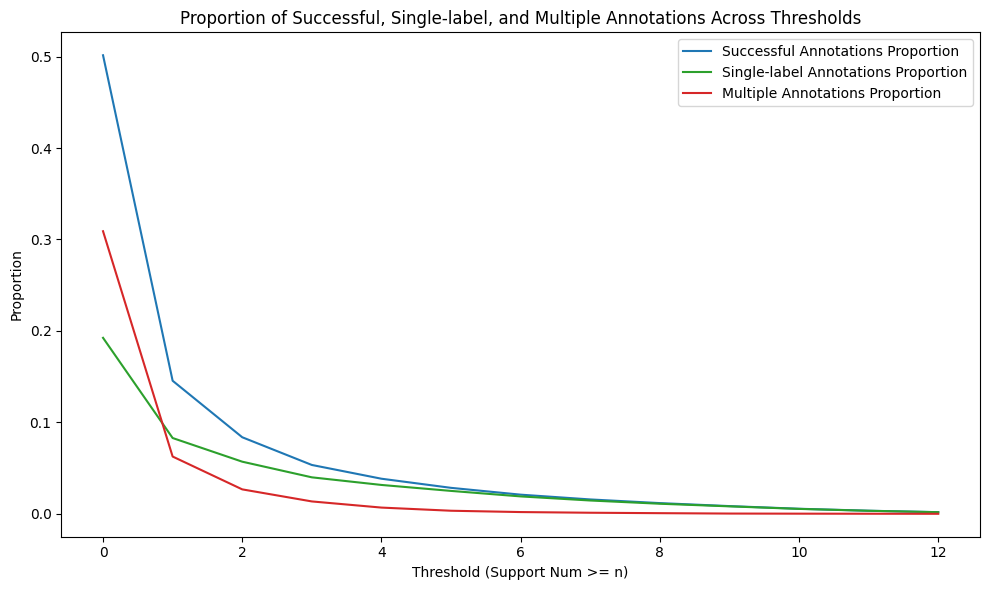

In [81]:
#how many annotated?
multi_label_proteins = propagation_df.groupby('protein_id').size()
proteins_with_multiple_annotations = multi_label_proteins[multi_label_proteins >= 2].count()
propagation_df.groupby('protein_id').filter(lambda x:len(x)>=2).protein_id.unique().shape

#plot as threshold gose
# Total number of unlabelled points (as provided)
import pandas as pd
import matplotlib.pyplot as plt

# Assume propagation_df is your dataframe

import pandas as pd
import matplotlib.pyplot as plt

# Assume propagation_df is your dataframe

# Total number of unlabelled points
total_unlabelled_points = 90384

# Initialize lists to store results
success_proportion = []
multi_label_proportion = []
single_label_proportion = []

# Set the range of thresholds
thresholds = range(0, 13)  # Thresholds from 0 to 12

# Calculate proportions for each threshold
for threshold in thresholds:
    
    # Filter proteins based on the threshold, only considering proteins with support_num >= threshold
    successful_proteins = propagation_df[propagation_df['support_num'] >= threshold]
    
    # Proportion of successfully annotated proteins
    success_count = successful_proteins['protein_id'].nunique()
    success_proportion.append(success_count / total_unlabelled_points)

    # Remove duplicates for each protein_id to check for multiple distinct labels
    unique_annotations = successful_proteins.drop_duplicates(subset=['protein_id', 'propagation_label'])
    
    # Group by protein_id and count distinct labels for each protein_id
    multi_label_success = unique_annotations.groupby('protein_id').size()
    
    # Calculate the proportion of single-label annotations
    single_label_success_ratio = multi_label_success[multi_label_success == 1].count() / total_unlabelled_points
    multi_label_success_ratio = multi_label_success[multi_label_success > 1].count() / total_unlabelled_points
    
    single_label_proportion.append(single_label_success_ratio)
    multi_label_proportion.append(multi_label_success_ratio)
    

# Plot the results with a single y-axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the proportion of successful annotations, single-label, and multiple-label annotations on the same axis
ax.set_xlabel('Threshold (Support Num >= n)')
ax.set_ylabel('Proportion')
ax.plot(thresholds, success_proportion, label='Successful Annotations Proportion', color='tab:blue')
ax.plot(thresholds, single_label_proportion, label='Single-label Annotations Proportion', color='tab:green')
ax.plot(thresholds, multi_label_proportion, label='Multiple Annotations Proportion', color='tab:red')
ax.tick_params(axis='y')

# Add title and legend
plt.title('Proportion of Successful, Single-label, and Multiple Annotations Across Thresholds')
ax.legend(loc="upper right")

# Display the plot
plt.tight_layout()
plt.show()

In [23]:
umap_has_label = pd.read_csv('../../Output/ESM/ESM_Embedding_Cosmograph/esm3_has_pfam_labels.csv')

threshold = 0
    
# Filter proteins based on the threshold, only considering proteins with support_num >= threshold
successful_proteins_id = propagation_df[propagation_df['support_num'] >= threshold].protein_id.to_list()

# 使用矢量化操作代替 apply
umap_has_label.loc[umap_has_label['id'].isin(successful_proteins_id), 'type'] = 'new_assigned'


In [28]:
umap_has_label.to_csv('../../Output/ESM/ESM_Embedding_Cosmograph/esm3_knn_13_propagation.csv')

- What kind of labels are most assgined？

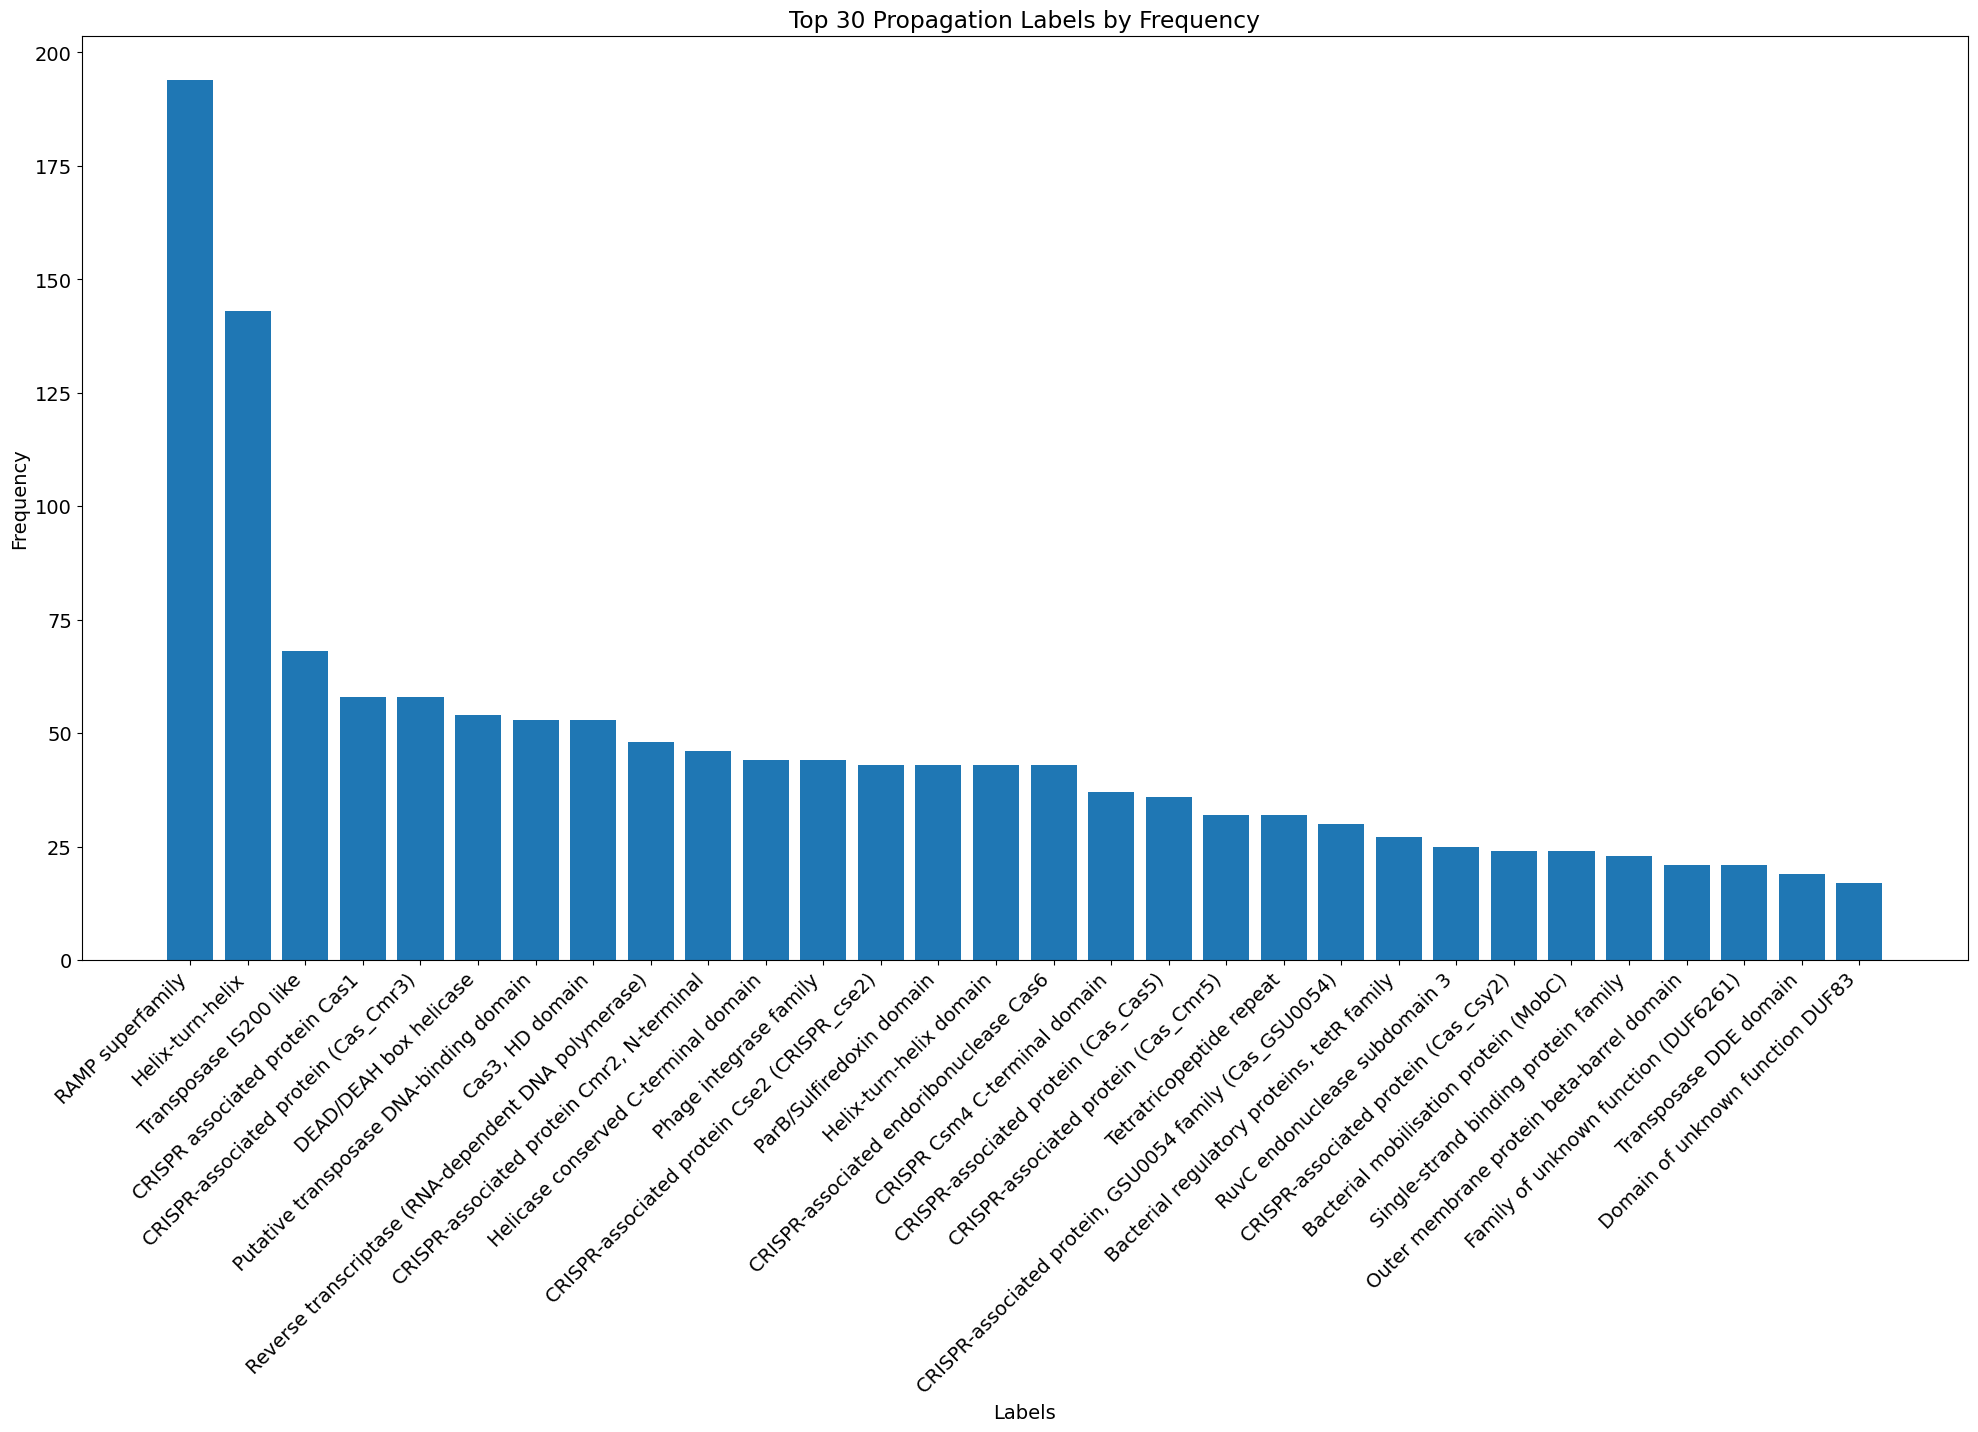

In [44]:
#find a threshold to see what kind of labels are assigned?
from matplotlib import rc


threshold = k/2 - 1
propagation_filter_df = propagation_df[propagation_df['support_num']>=threshold].reset_index(drop=True)
propagation_filter_df = propagation_filter_df.drop_duplicates(subset=['Protein accession','propagation_label'])

#let's see what kind of labels are assigned
propagation_filter_label = propagation_filter_df.propagation_label.values
propagation_filter_label_counts = propagation_filter_df.propagation_label.value_counts()

umap_embedding_euc_all_pfam_no_duplicated_label_counts = umap_embedding_euc_all_pfam_no_duplicated_df.loc[:,'Signature description'].value_counts()
# Plot histogram with x-axis sorted by frequency
plt.rcParams.update({'font.size': 14})
# Assuming that the necessary DataFrames 'propagation_filter_df' and 'umap_embedding_euc_all_pfam_no_duplicated_df' are available

# Set global font size to 14
plt.rcParams.update({'font.size': 14})

# Create the figure for two plots (one above the other)
plt.figure(figsize=(20,24))

# First plot: Top 30 Propagation Labels
plt.subplot(2, 1, 1)
plt.bar(propagation_filter_label_counts.index[0:30], propagation_filter_label_counts.values[0:30])
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Top 30 Propagation Labels by Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()




See influence of repeat labels